# Model Selection

### Project Goal  : build a model predicting  `pa_approved` based on the following features<br>
- `bin`  The BIN of the payer(insurance company) for the claim.
- `drug`   The drug that was associated with the claim.
- `reject_code`   If the claim was rejected, what was the associated rejection code. It tells you the reason why the claim has been rejected.
- `correct_diagnosis`    Flag for information provided by the provider indicating that the patient has the correct diagnosis for the associated drug.
- `tried_and_failed`    Flag for information provided by the provider indicating that the patient has tried and failed the relevant generic alternatives.
- `contraindication`    Flag for information provided by the provider indicating that the patient has an associated contraindication for the medication requested.

### Summary of what have been done in the previous notebooks
- We concluded that the feature `reject_code` is redundant and dropped from our model
- We noticed that there were some nontrivial interaction between features and added the interaction terms of the pairs (`bin`, `drug`), (`tried_and_faild`,`drug`),(`contraindication`,`drug`).
- Using cross validation, we selected features and tuned hyperparameters.

### Summary of this notebook

For each key performance indicator, we will choose the model that optimizes the key performance indicator among the models(logistic regression, linear discriminant analysis etc.) with the features and hyperparameters that we chose in the previous notebook.<br><br>
In the end, we will be using `roc_auc` as our key performance indicator but we will also build machine learning models based on other key performance indicators i.e. `accuracy_score`,`precision`, `true_positive_rate`, `false_positive_rate` and `f1`.<br><br>
As a result, we will choose logistic regression as our machine learning model.

## 0. Load Libraries and Data

Recall that we split data into three parts 'pre'(`X_pre`,`y_pre`), 'train'(`X_train`, `y_train`) and 'test'(`X_test`, `y_test`).  `X_pre_inter`,`X_train_inter` and`X_test_inter` are `X_pre`,`X_train` and `X_test` with columns encoding interaction terms added.<br>
- `X_pre(_inter)`,`y_pre(_inter)` will be used for the exploratory data analysis, feature selection and hyperparameter tuning.
- `X_train`, `y_train` will be used for model selection.
- `X_test`, `y_test` will be used for model assessment.

In [1]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score,recall_score, f1_score, roc_auc_score, r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
X_pre = pd.read_csv('data/X_pre',index_col = 0)
X_train = pd.read_csv('data/X_train',index_col = 0)
X_inter_pre = pd.read_csv('data/X_inter_pre',index_col = 0)
X_inter_train = pd.read_csv('data/X_inter_train',index_col = 0)
y_pre = pd.read_csv('data/y_pre',index_col = 0)
y_train = pd.read_csv('data/y_train',index_col = 0)
# load selected features and tuned hyperparameters
paras = pd.read_csv('data/paras', index_col = 0)
feats = pd.read_csv('data/feats', index_col = 0)
# kfold object
kfold = StratifiedKFold(n_splits = 5,
                        shuffle = True,
                        random_state = 623)

In [3]:
for i in paras.index : 
    for j in paras.columns : 
           if type(paras.at[i,j])==str :
                paras.at[i,j] = ast.literal_eval(paras.loc[i,j])

In [4]:
for i in feats.index : 
    for j in feats.columns : 
       feats.loc[i,j] = ast.literal_eval(feats.loc[i,j])

## 1. Model Evaluation

- With respect to each key performance indicator, we select the best performing model via cross validation on the training set with respect to the  the previously selected features and hyperparameters.
- We will used `X_train`, `X_train_inter` and `y_train` to evaluate models.

- `kpis` : a short for key performance inidcators. This is where we will store the key performance indicators of the models with tuned hyperparameters and selected features.

In [5]:
kpis = pd.DataFrame(data = {'accuracy_score' : [0,0,0,0,0,0,0],
                            'precision' : [0,0,0,0,0,0,0],
                            'true_positive_rate' : [0,0,0,0,0,0,0],
                            'false_positive_rate' : [0,0,0,0,0,0,0],
                            'f1' : [0,0,0,0,0,0,0],
                            'roc_auc' : [0,0,0,0,0,0,0]},
                    index=['Base','Log', 'LDA','SVM','DT','RF','XGB'])

In [6]:
kpis

,accuracy_score,precision,true_positive_rate,false_positive_rate,f1,roc_auc
Base,0,0,0,0,0,0
Log,0,0,0,0,0,0
LDA,0,0,0,0,0,0
SVM,0,0,0,0,0,0
DT,0,0,0,0,0,0
RF,0,0,0,0,0,0
XGB,0,0,0,0,0,0


### -Baseline Model-

In [7]:
# cross validation key performance indicators
acses = np.zeros(5)
pres = np.zeros(5)
tprs = np.zeros(5)
fprs = np.zeros(5)
f1s = np.zeros(5)
aucs = np.zeros(5)

In [8]:
# cross validation computing key performance indicators
i=0
for train_index, test_index in kfold.split(X_inter_pre, y_pre) :
    y_ho = y_pre.iloc[test_index].copy()
    
    pred = np.ones(y_ho.shape[0])
    pred_proba = np.ones(y_ho.shape[0]) 
    
    acses[i] = accuracy_score(y_ho.values, pred)
    conf_mat = confusion_matrix(y_ho, pred)
    pres[i] = precision_score(y_ho, pred)
    tprs[i] = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
    fprs[i] = conf_mat[0,1]/(conf_mat[0,0] + conf_mat[0,1])
    f1s[i] = f1_score(y_ho, pred)
    aucs[i] = roc_auc_score(y_ho, pred_proba)   
    i=i+1

In [9]:
# key performance indicators
kpis.loc['Base', 'accuracy_score'] = round(acses.mean(),3)
kpis.loc['Base', 'precision'] = round(pres.mean(),3)
kpis.loc['Base', 'true_positive_rate'] = round(tprs.mean(),3)
kpis.loc['Base', 'false_positive_rate'] = round(fprs.mean(),3)
kpis.loc['Base', 'f1'] = round(f1s.mean(),3)
kpis.loc['Base', 'roc_auc'] = round(aucs.mean(),3)

In [10]:
kpis

,accuracy_score,precision,true_positive_rate,false_positive_rate,f1,roc_auc
Base,0.734,0.734,1,1,0.847,0.5
Log,0.000,0.000,0,0,0.000,0.0
LDA,0.000,0.000,0,0,0.000,0.0
SVM,0.000,0.000,0,0,0.000,0.0
DT,0.000,0.000,0,0,0.000,0.0
RF,0.000,0.000,0,0,0.000,0.0
XGB,0.000,0.000,0,0,0.000,0.0


### -Logistic Regression-

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
# cross validation key performance indicators
acses = np.zeros(5)
pres = np.zeros(5)
tprs = np.zeros(5)
fprs = np.zeros(5)
f1s = np.zeros(5)
aucs = np.zeros(5)

In [13]:
# cross validation computing key performance indicators
i=0
for train_index, test_index in kfold.split(X_inter_train, y_train) :
    X_tt = X_inter_train.iloc[train_index, :].copy()
    X_ho = X_inter_train.iloc[test_index, :].copy()
    y_tt = y_train.iloc[train_index].copy()
    y_ho = y_train.iloc[test_index].copy()
    
    # accuracy_score
    log_reg = LogisticRegression(penalty = paras.loc['Log','accuracy_score']['penalty'], 
                                 C=paras.loc['Log','accuracy_score']['C'],
                                 solver='liblinear',
                                 max_iter = 100)
    log_reg.fit(X_tt.values, y_tt.values)
    pred = log_reg.predict(X_ho.values)
    acses[i] = accuracy_score(y_ho.values, pred)

    # precision
    log_reg = LogisticRegression(penalty = paras.loc['Log','precision']['penalty'], 
                                 C=paras.loc['Log','precision']['C'],
                                 solver = 'saga',
                                 max_iter = 100, 
                                 l1_ratio = .5)
    log_reg.fit(X_tt.values, y_tt.values)
    pred = log_reg.predict(X_ho.values)
    pres[i] = precision_score(y_ho, pred)
    
    # true_positive_rate
    log_reg = LogisticRegression(penalty = paras.loc['Log','true_positive_rate']['penalty'], 
                                 C=paras.loc['Log','true_positive_rate']['C'],
                                 solver = 'saga',
                                 max_iter = 100, 
                                 l1_ratio = .5)
    log_reg.fit(X_tt.values, y_tt.values)
    pred = log_reg.predict(X_ho.values)
    conf_mat = confusion_matrix(y_ho, pred)
    tprs[i] = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])

    # false_positive_rate
    log_reg = LogisticRegression(penalty = paras.loc['Log','false_positive_rate']['penalty'], 
                                 C=paras.loc['Log','false_positive_rate']['C'],
                                 solver = 'saga',
                                 max_iter = 100, 
                                 l1_ratio = .5)
    log_reg.fit(X_tt.values, y_tt.values)
    pred = log_reg.predict(X_ho.values)
    conf_mat = confusion_matrix(y_ho, pred)
    fprs[i] = conf_mat[0,1]/(conf_mat[0,0] + conf_mat[0,1])
    
    # f1
    log_reg = LogisticRegression(penalty = paras.loc['Log','f1']['penalty'], 
                                 C=paras.loc['Log','f1']['C'],
                                 solver = 'saga',
                                 max_iter = 100, 
                                 l1_ratio = .5)
    log_reg.fit(X_tt.values, y_tt.values)
    pred = log_reg.predict(X_ho.values)
    f1s[i] = f1_score(y_ho, pred)
    
    # roc_auc
    log_reg = LogisticRegression(penalty = paras.loc['Log','roc_auc']['penalty'], 
                                 C=paras.loc['Log','roc_auc']['C'], 
                                 solver= 'saga',
                                 max_iter = 100,
                                l1_ratio = .5)
    log_reg.fit(X_tt.values, y_tt.values)
    pred_proba = log_reg.predict_proba(X_ho.values)[:,1]
    aucs[i] = roc_auc_score(y_ho, pred_proba)
    i=i+1        

In [14]:
# key performance indicators
kpis.loc['Log','accuracy_score'] = round(np.mean(acses),3)
kpis.loc['Log','precision'] = round(np.mean(pres),3)
kpis.loc['Log','true_positive_rate'] = round(np.mean(tprs),3)
kpis.loc['Log','false_positive_rate'] = round(np.mean(fprs),3)
kpis.loc['Log','f1'] = round(np.mean(f1s),3)
kpis.loc['Log','roc_auc'] = round(np.mean(aucs),3)

In [15]:
kpis

,accuracy_score,precision,true_positive_rate,false_positive_rate,f1,roc_auc
Base,0.734,0.734,1.000,1.000,0.847,0.500
Log,0.815,0.832,0.938,0.524,0.882,0.879
LDA,0.000,0.000,0.000,0.000,0.000,0.000
SVM,0.000,0.000,0.000,0.000,0.000,0.000
DT,0.000,0.000,0.000,0.000,0.000,0.000
RF,0.000,0.000,0.000,0.000,0.000,0.000
XGB,0.000,0.000,0.000,0.000,0.000,0.000


### -Linear Discriminant Analysis-

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()

In [17]:
# cross validation key performance indicators
acses = np.zeros(5)
pres = np.zeros(5)
tprs = np.zeros(5)
fprs = np.zeros(5)
f1s = np.zeros(5)
aucs = np.zeros(5)

In [18]:
# cross validation computing key performance indicators
i=0
for train_index, test_index in kfold.split(X_train, y_train) : 
    X_tt = X_train.iloc[train_index, :].copy()
    X_ho = X_train.iloc[test_index, :].copy()
    y_tt = y_train.iloc[train_index].copy()
    y_ho = y_train.iloc[test_index].copy()
           
    # accuracy_score
    lda.fit(X_tt[feats.loc['LDA','accuracy_score']].values, y_tt.values)
    pred = lda.predict(X_ho[feats.loc['LDA','accuracy_score']].values)
    acses[i] = accuracy_score(y_ho, pred)
    
    # precision
    lda.fit(X_tt[feats.loc['LDA','precision']].values, y_tt.values)
    pred = lda.predict(X_ho[feats.loc['LDA','precision']].values)
    pres[i] = precision_score(y_ho, pred)
    
    # true_positive_rate
    lda.fit(X_tt[feats.loc['LDA','true_positive_rate']].values, y_tt.values)
    pred = lda.predict(X_ho[feats.loc['LDA','true_positive_rate']].values)
    conf_mat = confusion_matrix(y_ho, pred)
    tprs[i] = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
    
    # false_positive_rate
    lda.fit(X_tt[feats.loc['LDA','false_positive_rate']].values, y_tt.values)
    pred = lda.predict(X_ho[feats.loc['LDA','false_positive_rate']].values)
    conf_mat = confusion_matrix(y_ho, pred)
    fprs[i] = conf_mat[0,1]/(conf_mat[0,0] + conf_mat[0,1])
    
    # f1
    lda.fit(X_tt[feats.loc['LDA','f1']].values, y_tt.values)
    pred = lda.predict(X_ho[feats.loc['LDA','f1']].values)
    f1s[i] = f1_score(y_ho, pred)
    
    # roc_auc
    lda.fit(X_tt[feats.loc['LDA','roc_auc']].values, y_tt.values)
    pred_proba = lda.predict_proba(X_ho[feats.loc['LDA','roc_auc']].values)[:, 1]
    aucs[i] = roc_auc_score(y_ho, pred_proba)
  
    i=i+1

In [19]:
# key performance indicators
kpis.loc['LDA','accuracy_score'] = round(np.mean(acses),3)
kpis.loc['LDA','precision'] = round(np.mean(pres),3)
kpis.loc['LDA','true_positive_rate'] = round(np.mean(tprs),3)
kpis.loc['LDA','false_positive_rate'] = round(np.mean(fprs),3)
kpis.loc['LDA','f1'] = round(np.mean(f1s),3)
kpis.loc['LDA','roc_auc'] = round(np.mean(aucs),3)

In [20]:
kpis

,accuracy_score,precision,true_positive_rate,false_positive_rate,f1,roc_auc
Base,0.734,0.734,1.000,1.000,0.847,0.500
Log,0.815,0.832,0.938,0.524,0.882,0.879
LDA,0.784,0.793,1.000,1.000,0.866,0.721
SVM,0.000,0.000,0.000,0.000,0.000,0.000
DT,0.000,0.000,0.000,0.000,0.000,0.000
RF,0.000,0.000,0.000,0.000,0.000,0.000
XGB,0.000,0.000,0.000,0.000,0.000,0.000


### -Support Vector Machine-

In [21]:
from sklearn.svm import SVC

In [22]:
# cross validation key performance indicators
acses = np.zeros(5)
pres = np.zeros(5)
tprs = np.zeros(5)
fprs = np.zeros(5)
f1s = np.zeros(5)
aucs = np.zeros(5)

In [23]:
# cross validation computing key performance indicators
i=0
for train_index, test_index in kfold.split(X_train, y_train) : 
    X_tt = X_train.iloc[train_index,:].copy()
    X_ho = X_train.iloc[test_index, :].copy()
    y_tt = y_train.iloc[train_index].copy()
    y_ho = y_train.iloc[test_index].copy()
    
    # accuracy_score
    svc = SVC(C = paras.loc['SVM','accuracy_score']['margin'], 
          max_iter = 10, 
          probability = True)
    svc.fit(X_tt.loc[:,feats.loc['SVM','accuracy_score']].values, y_tt.values)
    pred = svc.predict(X_ho.loc[:,feats.loc['SVM','accuracy_score']].values)
    acses[i] = accuracy_score(y_ho, pred)
    
    # precision
    svc = SVC(C = paras.loc['SVM','precision']['margin'], 
          max_iter = 10, 
          probability = True)
    svc.fit(X_tt.loc[:,feats.loc['SVM','precision']].values, y_tt.values)
    pred = svc.predict(X_ho.loc[:,feats.loc['SVM','precision']].values)
    pres[i] = precision_score(y_ho, pred)
    
    # true_positive_rate
    svc = SVC(C = paras.loc['SVM','true_positive_rate']['margin'], 
          max_iter = 10, 
          probability = True)
    svc.fit(X_tt.loc[:,feats.loc['SVM','true_positive_rate']].values, y_tt.values)
    pred = svc.predict(X_ho.loc[:,feats.loc['SVM','true_positive_rate']].values)
    conf_mat = confusion_matrix(y_ho, pred)
    tprs[i] = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
    
    # false_positive_rate
    svc = SVC(C = paras.loc['SVM','false_positive_rate']['margin'], 
          max_iter = 10, 
          probability = True)
    svc.fit(X_tt.loc[:,feats.loc['SVM','false_positive_rate']].values, y_tt.values)
    pred = svc.predict(X_ho.loc[:,feats.loc['SVM','false_positive_rate']].values)
    conf_mat = confusion_matrix(y_ho, pred)
    fprs[i] = conf_mat[0,1]/(conf_mat[0,0] + conf_mat[0,1])
    
    # f1
    svc = SVC(C = paras.loc['SVM','f1']['margin'], 
          max_iter = 10, 
          probability = True)
    svc.fit(X_tt.loc[:,feats.loc['SVM','f1']].values, y_tt.values)
    pred = svc.predict(X_ho.loc[:,feats.loc['SVM','f1']].values)
    f1s[i] = f1_score(y_ho, pred)
    
    # roc_auc
    svc = SVC(C = paras.loc['SVM','roc_auc']['margin'], 
          max_iter = 10, 
          probability = True)
    svc.fit(X_tt.loc[:,feats.loc['SVM','roc_auc']].values, y_tt.values)
    pred_proba = svc.decision_function(X_ho.loc[:,feats.loc['SVM','roc_auc']].values)
    pred_proba = (pred_proba - pred_proba.min()) / (pred_proba.max() - pred_proba.min())    
    aucs[i] = roc_auc_score(y_ho, pred_proba)
    i=i+1

In [24]:
# key performance indicators
kpis.loc['SVM','accuracy_score'] = round(np.mean(acses),3)
kpis.loc['SVM','precision'] = round(np.mean(pres),3)
kpis.loc['SVM','true_positive_rate'] = round(np.mean(tprs),3)
kpis.loc['SVM','false_positive_rate'] = round(np.mean(fprs),3)
kpis.loc['SVM','f1'] = round(np.mean(f1s),3)
kpis.loc['SVM','roc_auc'] = round(np.mean(aucs),3)

In [25]:
kpis

,accuracy_score,precision,true_positive_rate,false_positive_rate,f1,roc_auc
Base,0.734,0.734,1.000,1.000,0.847,0.500
Log,0.815,0.832,0.938,0.524,0.882,0.879
LDA,0.784,0.793,1.000,1.000,0.866,0.721
SVM,0.515,0.727,0.538,0.549,0.611,0.468
DT,0.000,0.000,0.000,0.000,0.000,0.000
RF,0.000,0.000,0.000,0.000,0.000,0.000
XGB,0.000,0.000,0.000,0.000,0.000,0.000


### -Decision Tree-

In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
# cross validation key performance indicators
acses = np.zeros(5)
pres = np.zeros(5)
tprs = np.zeros(5)
fprs = np.zeros(5)
f1s = np.zeros(5)
aucs = np.zeros(5)
# feature importance scores
acs_importance = np.zeros(len(X_train.columns))
pre_importance = np.zeros(len(X_train.columns))
tpr_importance = np.zeros(len(X_train.columns))
fpr_importance = np.zeros(len(X_train.columns))
f1_importance = np.zeros(len(X_train.columns))
auc_importance = np.zeros(len(X_train.columns))

In [28]:
# cross validation computing key performance indicators
i=0
for train_index, test_index in kfold.split(X_train, y_train) : 
    X_tt = X_train.iloc[train_index, :].copy()
    X_ho = X_train.iloc[test_index, :].copy()
    y_tt = y_train.iloc[train_index].copy()
    y_ho = y_train.iloc[test_index].copy()
    
    # accuracy_score
    dt = DecisionTreeClassifier(max_depth = paras.loc['DT','accuracy_score']['max_depth'])
    dt.fit(X_tt.values, y_tt.values)
    pred = dt.predict(X_ho.values)
    acses[i] = accuracy_score(y_ho, pred)
    acs_importance = acs_importance + dt.feature_importances_
    
    # precision
    dt = DecisionTreeClassifier(max_depth = paras.loc['DT','precision']['max_depth'])
    dt.fit(X_tt.values, y_tt.values)
    pred = dt.predict(X_ho.values)
    pres[i] = precision_score(y_ho, pred)
    pre_importance = pre_importance + dt.feature_importances_
    
    # true_positive_rate
    dt = DecisionTreeClassifier(max_depth = paras.loc['DT','true_positive_rate']['max_depth'])
    dt.fit(X_tt.values, y_tt.values)
    pred = dt.predict(X_ho.values)
    conf_mat = confusion_matrix(y_ho, pred)
    tprs[i] = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
    tpr_importance = tpr_importance + dt.feature_importances_
    
    # false_positive_rate
    dt = DecisionTreeClassifier(max_depth = paras.loc['DT','false_positive_rate']['max_depth'])
    dt.fit(X_tt.values, y_tt.values)
    pred = dt.predict(X_ho.values)
    conf_mat = confusion_matrix(y_ho, pred)
    fprs[i] = conf_mat[0,1]/(conf_mat[0,0] + conf_mat[0,1])
    fpr_importance = fpr_importance + dt.feature_importances_
    
    # f1
    dt = DecisionTreeClassifier(max_depth = paras.loc['DT','f1']['max_depth'])
    dt.fit(X_tt.values, y_tt.values)
    pred = dt.predict(X_ho.values)
    f1s[i] = f1_score(y_ho, pred)
    f1_importance =f1_importance + dt.feature_importances_
    
    # roc_auc
    dt = DecisionTreeClassifier(max_depth = paras.loc['DT','roc_auc']['max_depth'])
    dt.fit(X_tt.values, y_tt.values)
    pred_proba = dt.predict_proba(X_ho.values)[:,1]
    aucs[i] = roc_auc_score(y_ho, pred_proba)
    auc_importance = auc_importance + dt.feature_importances_
    i=i+1

-accuracy_score feature importance-

correct_diagnosis : 0.003
tried_and_failed : 0.047
contraindication : 0.133
417380 : 0.234
417614 : 0.053
417740 : 0.091
999001 : 0.064
A : 0.107
B : 0.115
C : 0.154


double click the image to zoom in and out


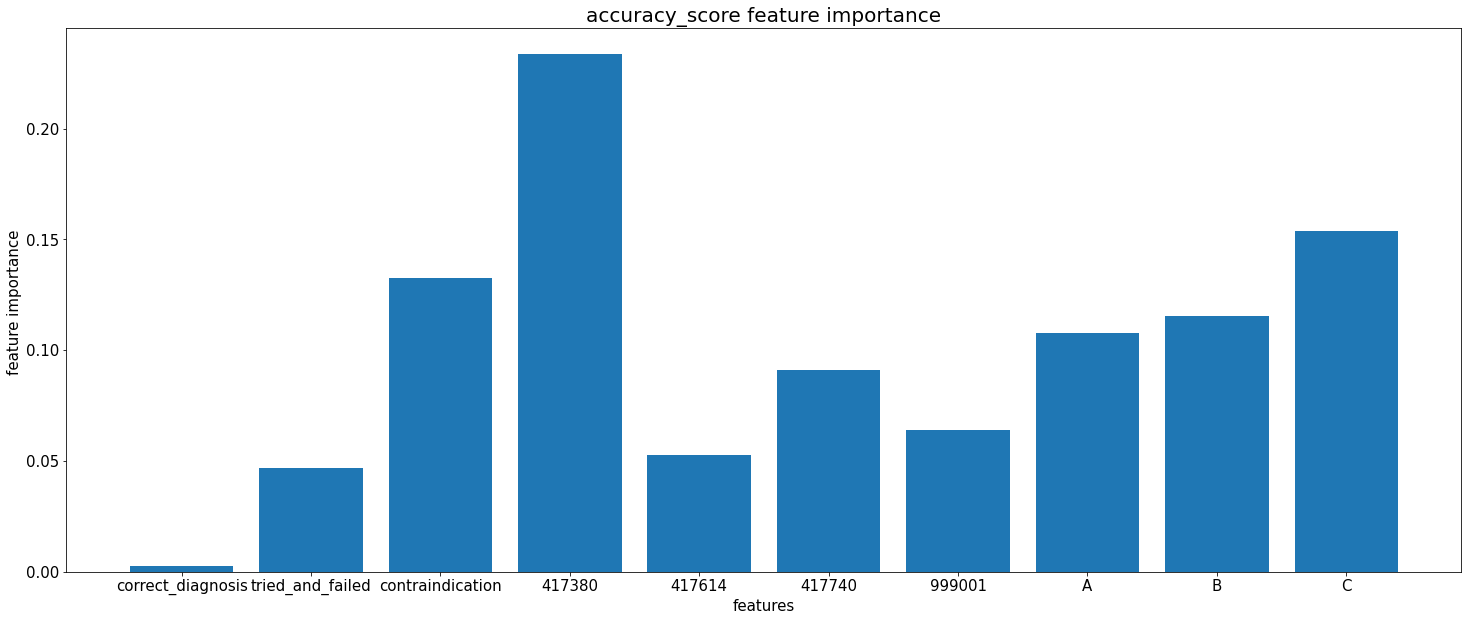



-precision feature importance-

correct_diagnosis : 0.003
tried_and_failed : 0.047
contraindication : 0.133
417380 : 0.23
417614 : 0.056
417740 : 0.092
999001 : 0.064
A : 0.121
B : 0.095
C : 0.16


double click the image to zoom in and out


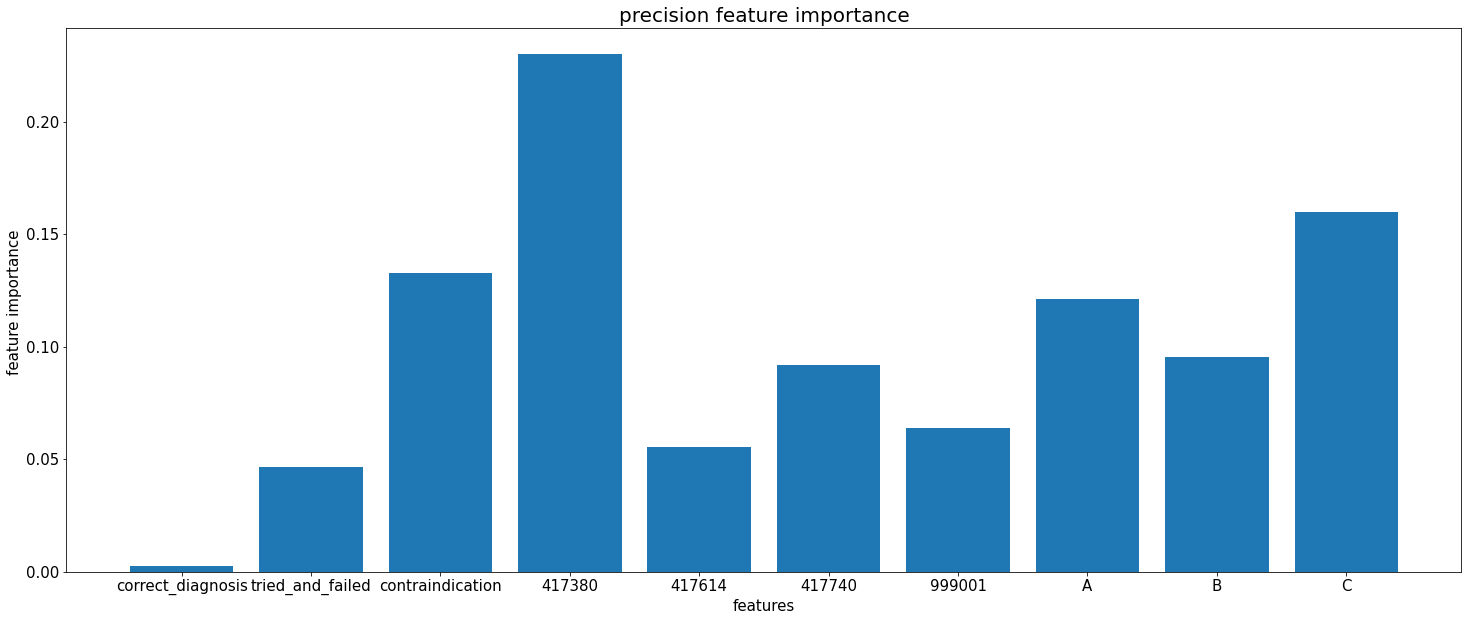



-true_positive_rate feature importance-

correct_diagnosis : 0.0
tried_and_failed : 0.0
contraindication : 1.0
417380 : 0.0
417614 : 0.0
417740 : 0.0
999001 : 0.0
A : 0.0
B : 0.0
C : 0.0


double click the image to zoom in and out


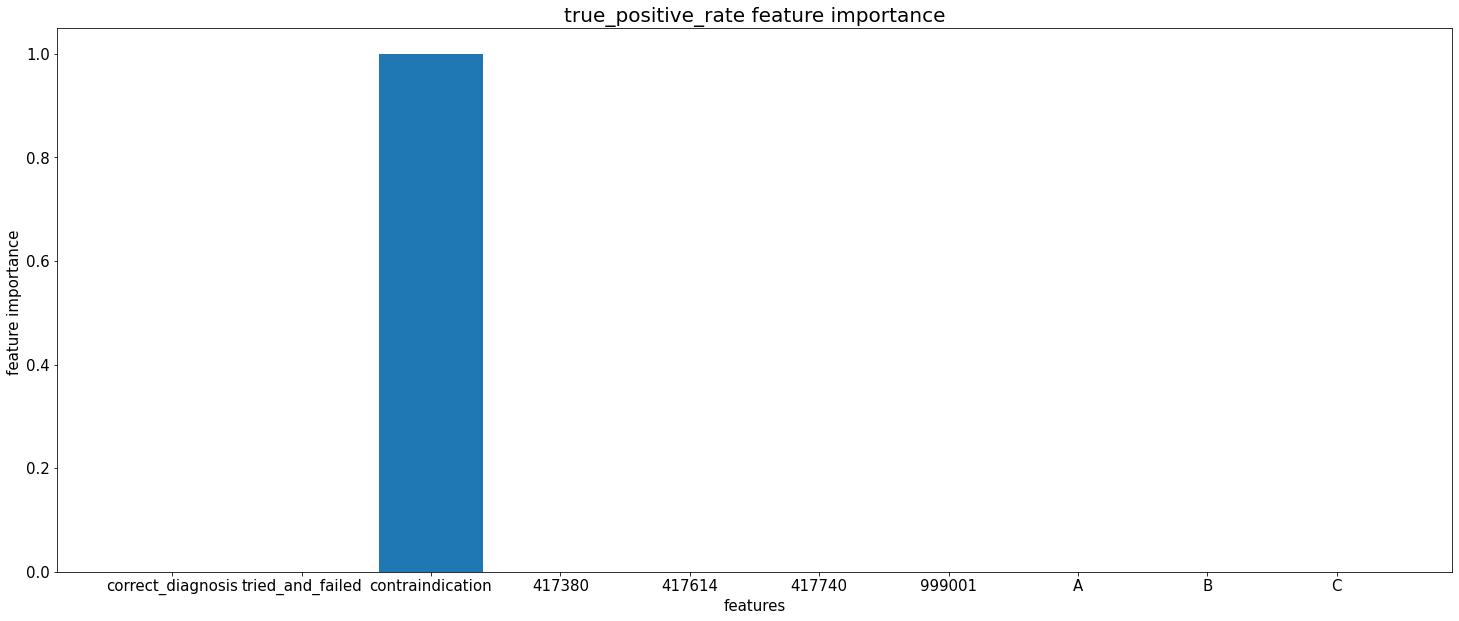



-false_positive_rate feature importance-

correct_diagnosis : 0.0
tried_and_failed : 0.0
contraindication : 1.0
417380 : 0.0
417614 : 0.0
417740 : 0.0
999001 : 0.0
A : 0.0
B : 0.0
C : 0.0


double click the image to zoom in and out


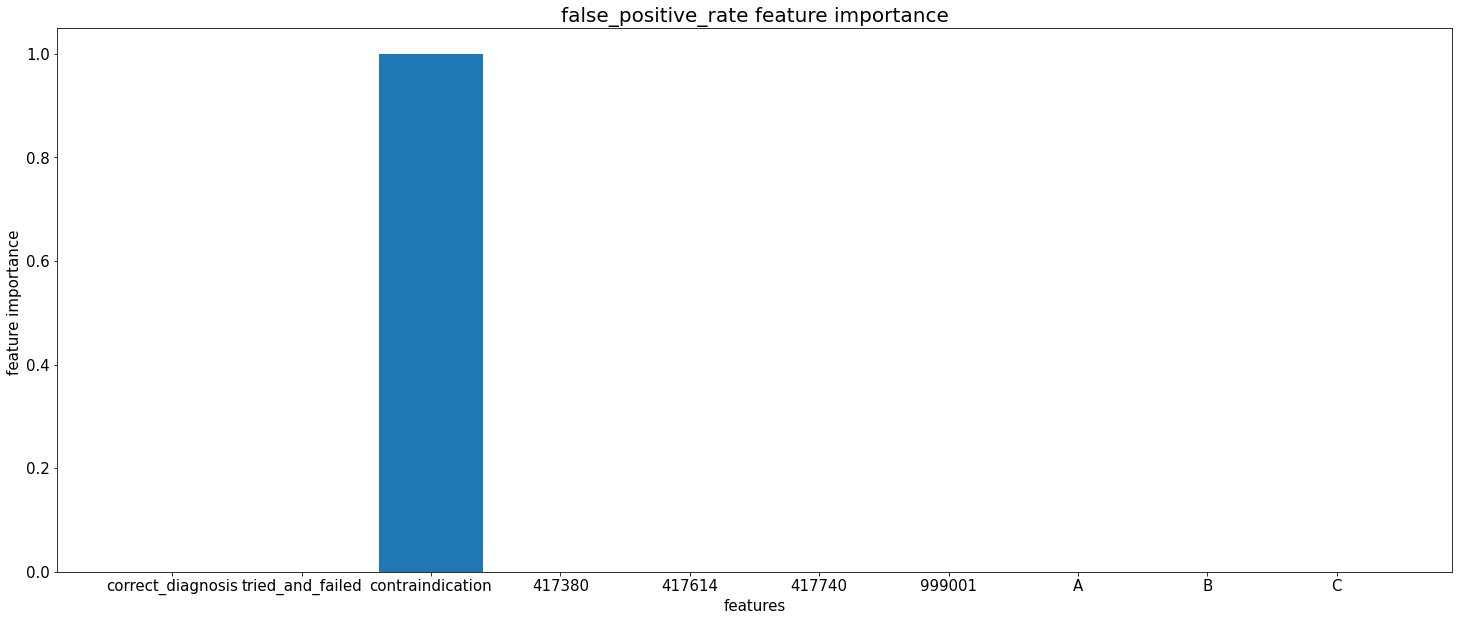



-f1 feature importance-

correct_diagnosis : 0.007
tried_and_failed : 0.046
contraindication : 0.132
417380 : 0.229
417614 : 0.069
417740 : 0.077
999001 : 0.064
A : 0.103
B : 0.124
C : 0.148


double click the image to zoom in and out


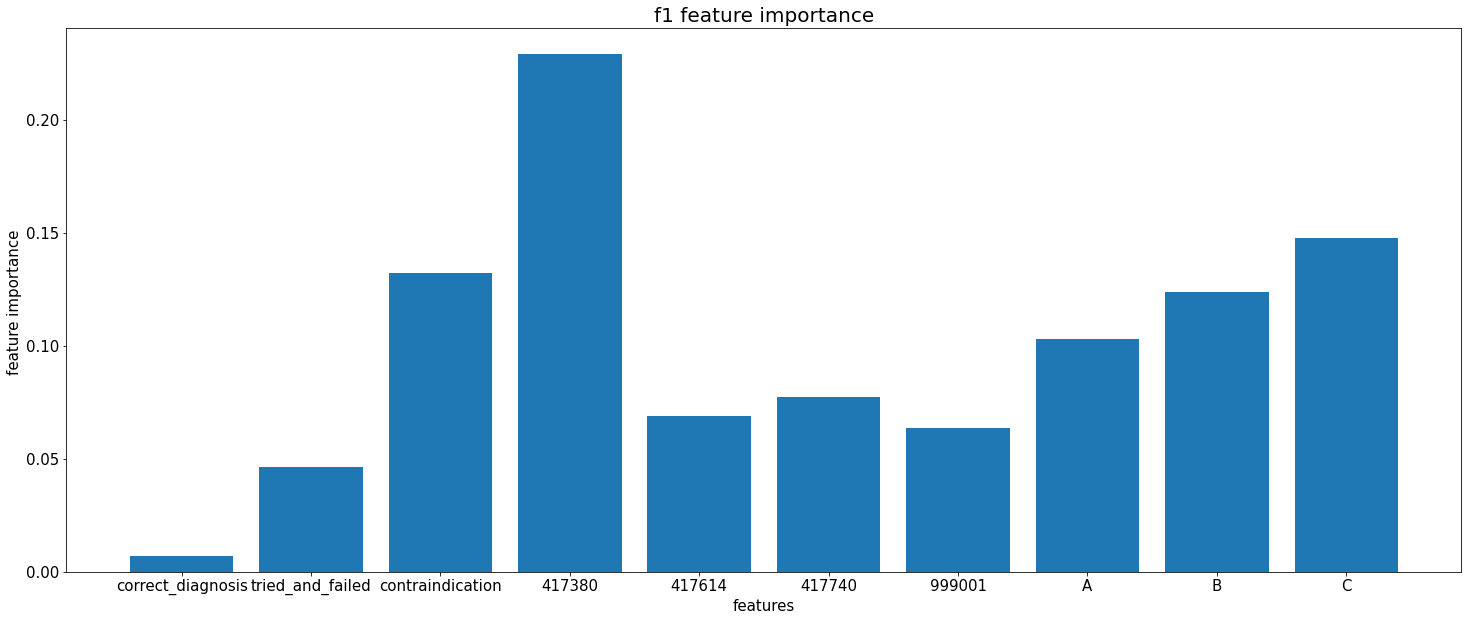



-roc_auc feature importance-

correct_diagnosis : 0.007
tried_and_failed : 0.046
contraindication : 0.132
417380 : 0.229
417614 : 0.074
417740 : 0.073
999001 : 0.064
A : 0.109
B : 0.116
C : 0.15


double click the image to zoom in and out


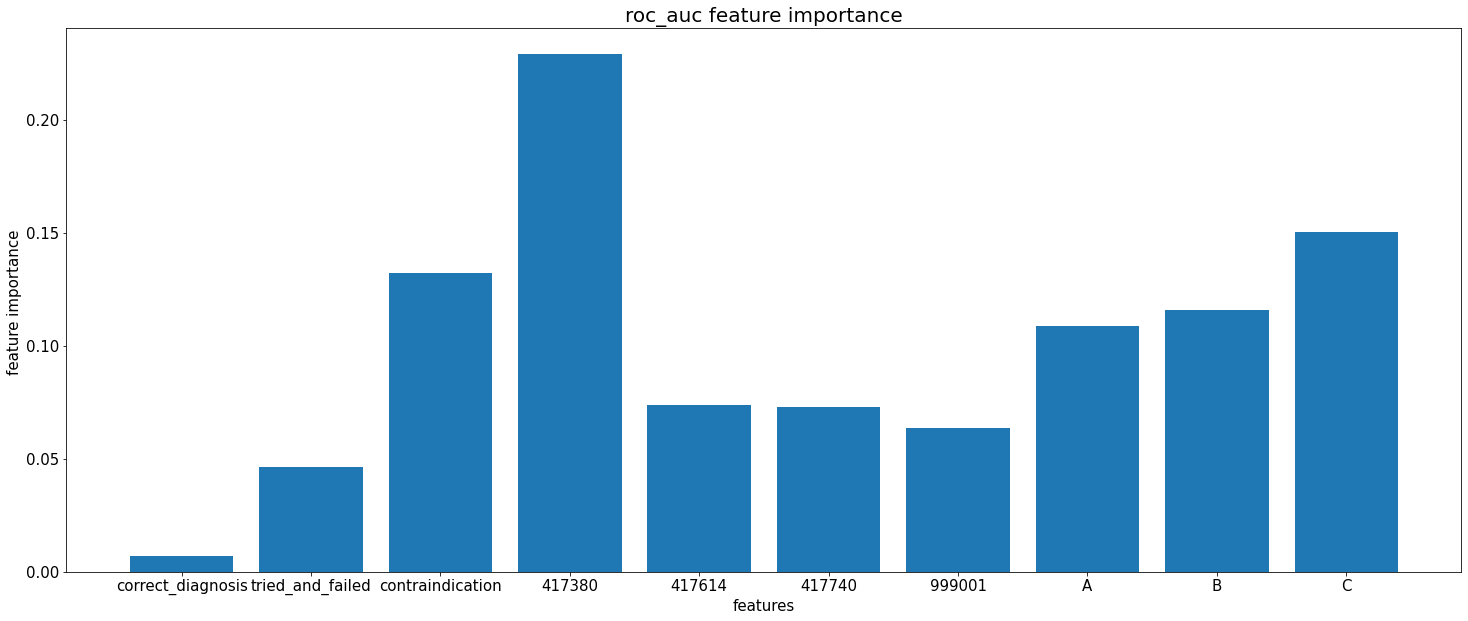

In [29]:
#summarize feature importances with respect to the accuracy_score
print('\033[1m'+'-accuracy_score feature importance-')
print('\033[0m')
for i in range(len(acs_importance)):
        print(X_train.columns[i],':',round(acs_importance[i]/5,3))
# plot feature importances with respect to the accuracy_score
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('accuracy_score feature importance', fontsize = 20)
plt.bar([x for x in X_pre.columns], acs_importance/5)
plt.show()  


print()
print()


#summarize feature importances with respect to the precision
print('\033[1m'+'-precision feature importance-')
print('\033[0m')
for i in range(len(pre_importance)):
        print(X_train.columns[i],':',round(pre_importance[i]/5,3))
# plot feature importances with respect to the precision
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('precision feature importance', fontsize = 20)
plt.bar([x for x in X_pre.columns], pre_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the true_positive_rate    
print('\033[1m'+'-true_positive_rate feature importance-')
print('\033[0m')
for i in range(len(tpr_importance)):
        print(X_train.columns[i],':',round(tpr_importance[i]/5,3))
# plot feature importances with respect to the true_positive_rate
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('true_positive_rate feature importance', fontsize = 20)
plt.bar([x for x in X_pre.columns], tpr_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the false_positive_rate 
print('\033[1m'+'-false_positive_rate feature importance-')
print('\033[0m')
for i in range(len(fpr_importance)):
        print(X_train.columns[i],':',round(fpr_importance[i]/5,3))
# plot feature importances with respect to the false_positive_rate
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('false_positive_rate feature importance', fontsize = 20)
plt.bar([x for x in X_pre.columns], fpr_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the f1   
print('\033[1m'+'-f1 feature importance-')
print('\033[0m')
for i in range(len(f1_importance)):
        print(X_train.columns[i],':',round(f1_importance[i]/5,3))
# plot feature importances with respect to the f1
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('f1 feature importance', fontsize = 20)
plt.bar([x for x in X_pre.columns], f1_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the roc_auc
print('\033[1m'+'-roc_auc feature importance-')
print('\033[0m')
for i in range(len(auc_importance)):
        print(X_train.columns[i],':',round(auc_importance[i]/5,3))
# plot feature importances with respect to the roc_auc
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('roc_auc feature importance', fontsize = 20)
plt.bar([x for x in X_pre.columns], auc_importance/5)
plt.show()  

In [30]:
X_train.columns

Index(['correct_diagnosis', 'tried_and_failed', 'contraindication', '417380',
       '417614', '417740', '999001', 'A', 'B', 'C'],
      dtype='object')

In [31]:
# accuracy_score
acs_importance[3] = max(acs_importance[3:7])
acs_importance[4] = max(acs_importance[7:])
acs_importance = acs_importance[:5]
# precision
pre_importance[3] = max(pre_importance[3:7])
pre_importance[4] = max(pre_importance[7:])
pre_importance = pre_importance[:5]
# true_positive_rate
tpr_importance[3] = max(tpr_importance[3:7])
tpr_importance[4] = max(tpr_importance[7:])
tpr_importance = tpr_importance[:5]
# false_positive_rate
fpr_importance[3] = max(fpr_importance[3:7])
fpr_importance[4] = max(fpr_importance[7:])
fpr_importance = fpr_importance[:5]
# f1
f1_importance[3] = max(f1_importance[3:7])
f1_importance[4] = max(f1_importance[7:])
f1_importance = f1_importance[:5]
# roc_auc
auc_importance[3] = max(auc_importance[3:7])
auc_importance[4] = max(auc_importance[7:])
auc_importance = auc_importance[:5]

In [32]:
features = list(X_train.columns.copy())
features[3] = 'bin'
features[4] = 'drug'
features = features[:5]
features

['correct_diagnosis', 'tried_and_failed', 'contraindication', 'bin', 'drug']

-accuracy_score feature importance-

correct_diagnosis : 0.003
tried_and_failed : 0.047
contraindication : 0.133
bin : 0.234
drug : 0.154


double click the image to zoom in and out


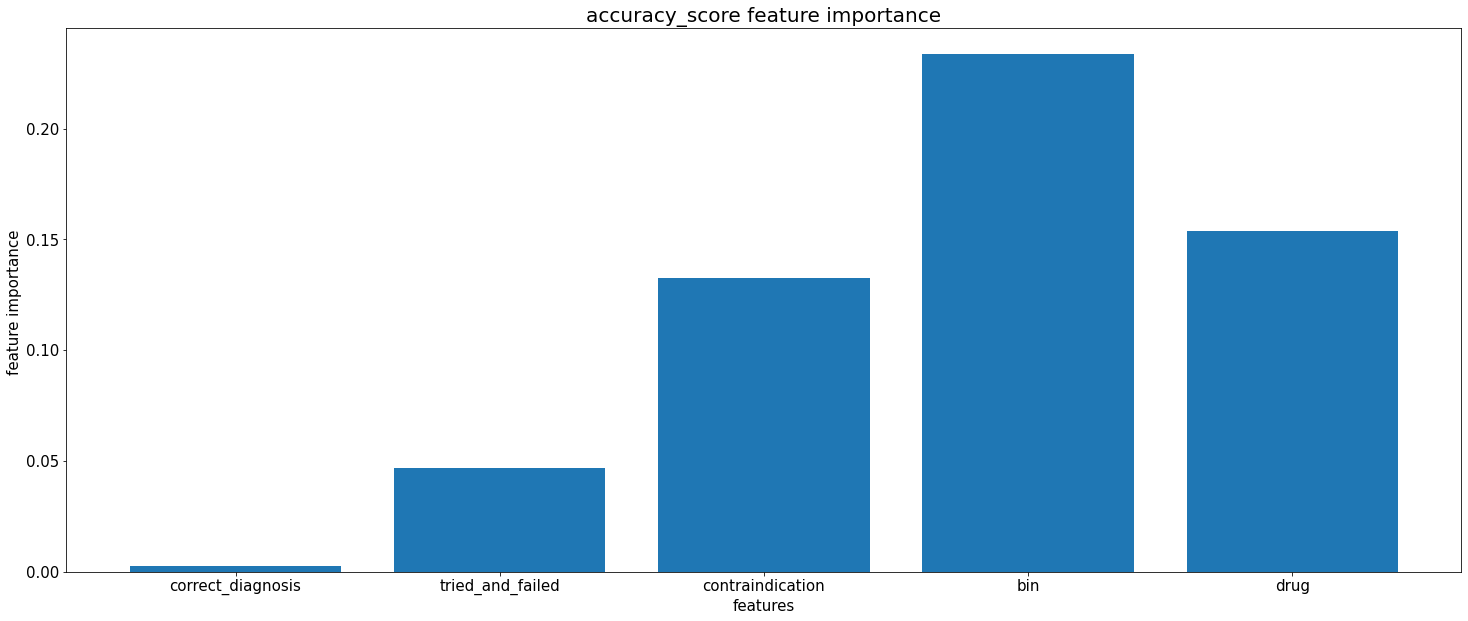



-precision feature importance-

correct_diagnosis : 0.003
tried_and_failed : 0.047
contraindication : 0.133
bin : 0.23
drug : 0.16


double click the image to zoom in and out


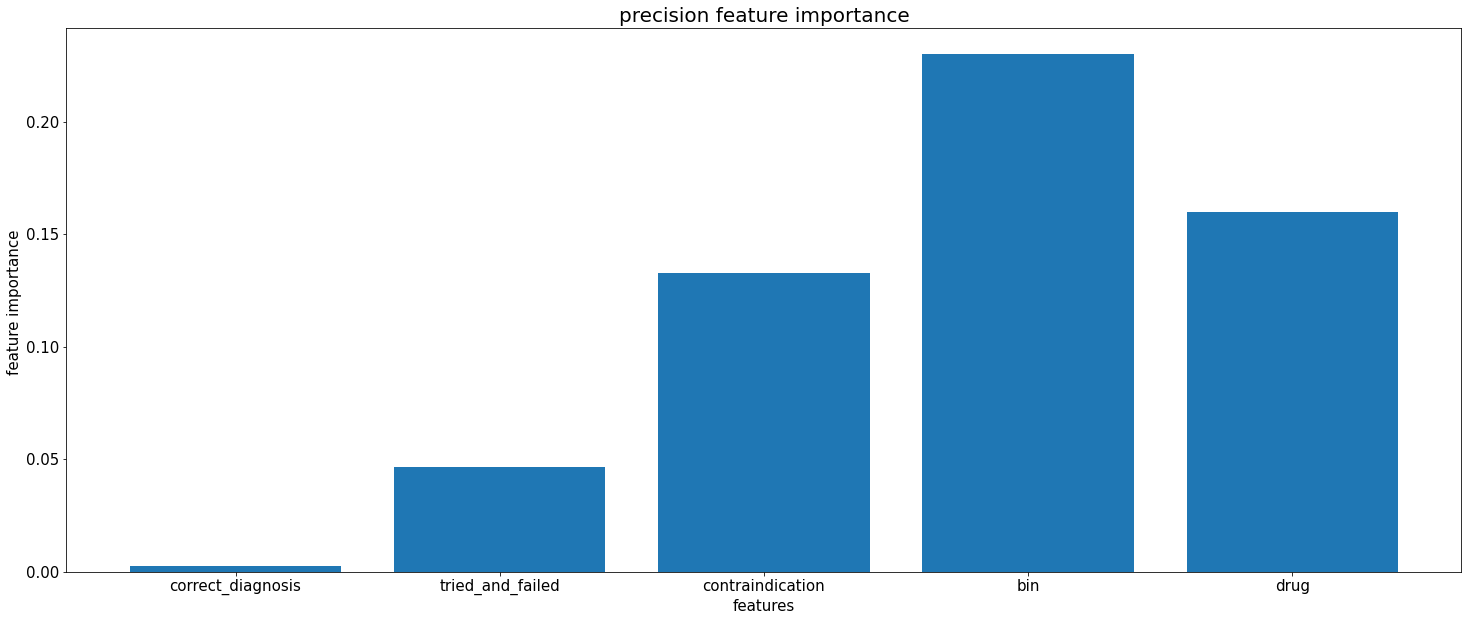



-true_positive_rate feature importance-

correct_diagnosis : 0.0
tried_and_failed : 0.0
contraindication : 1.0
bin : 0.0
drug : 0.0


double click the image to zoom in and out


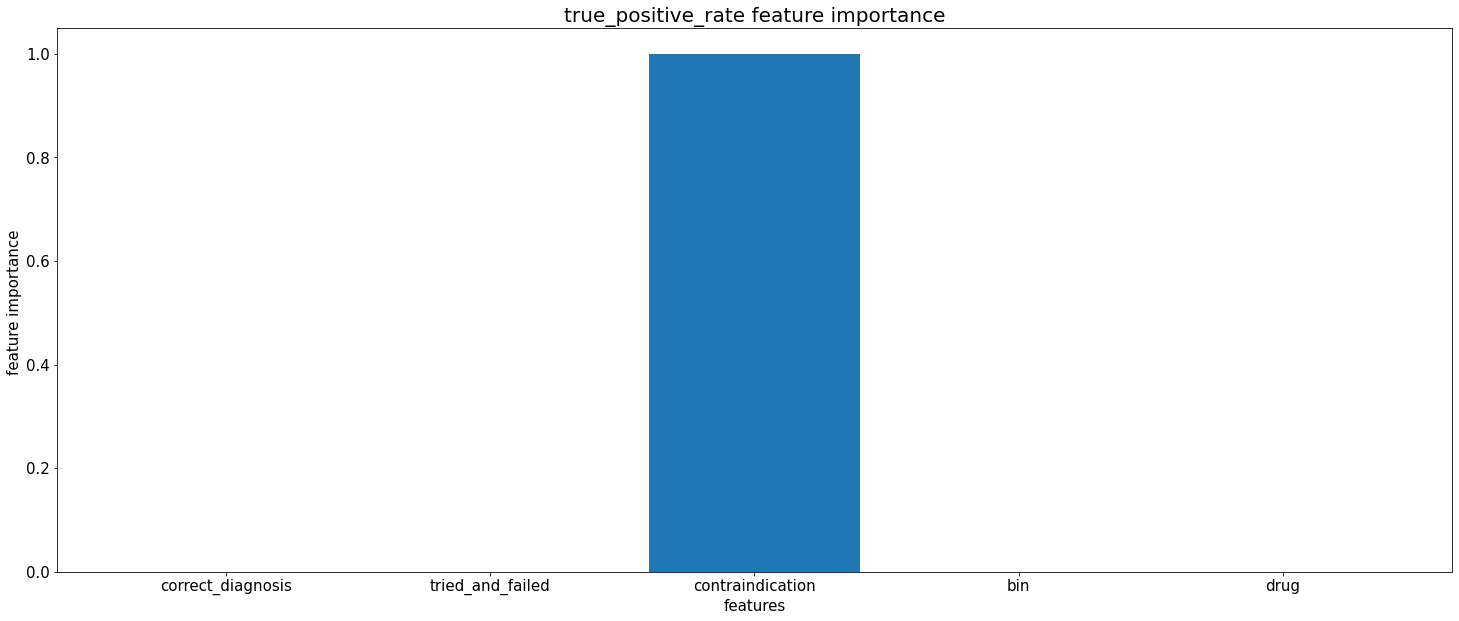



-false_positive_rate feature importance-

correct_diagnosis : 0.0
tried_and_failed : 0.0
contraindication : 1.0
bin : 0.0
drug : 0.0


double click the image to zoom in and out


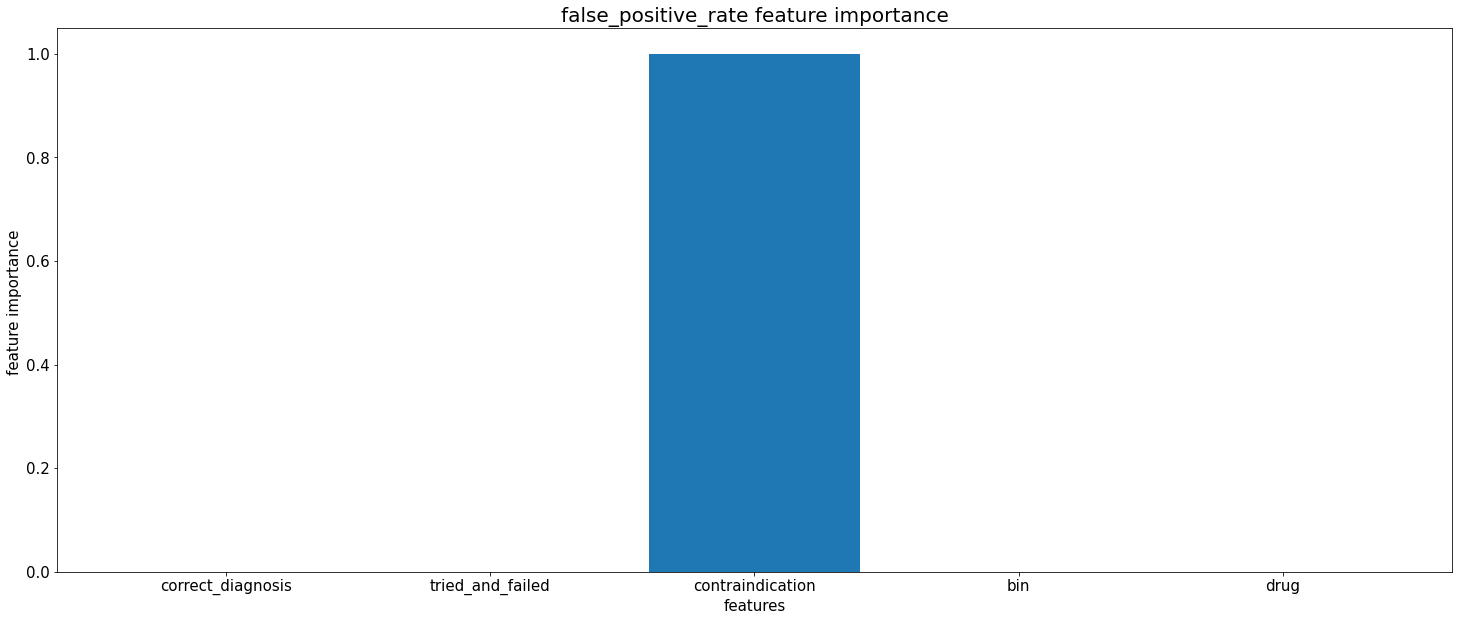



-f1 feature importance-

correct_diagnosis : 0.007
tried_and_failed : 0.046
contraindication : 0.132
bin : 0.229
drug : 0.148


double click the image to zoom in and out


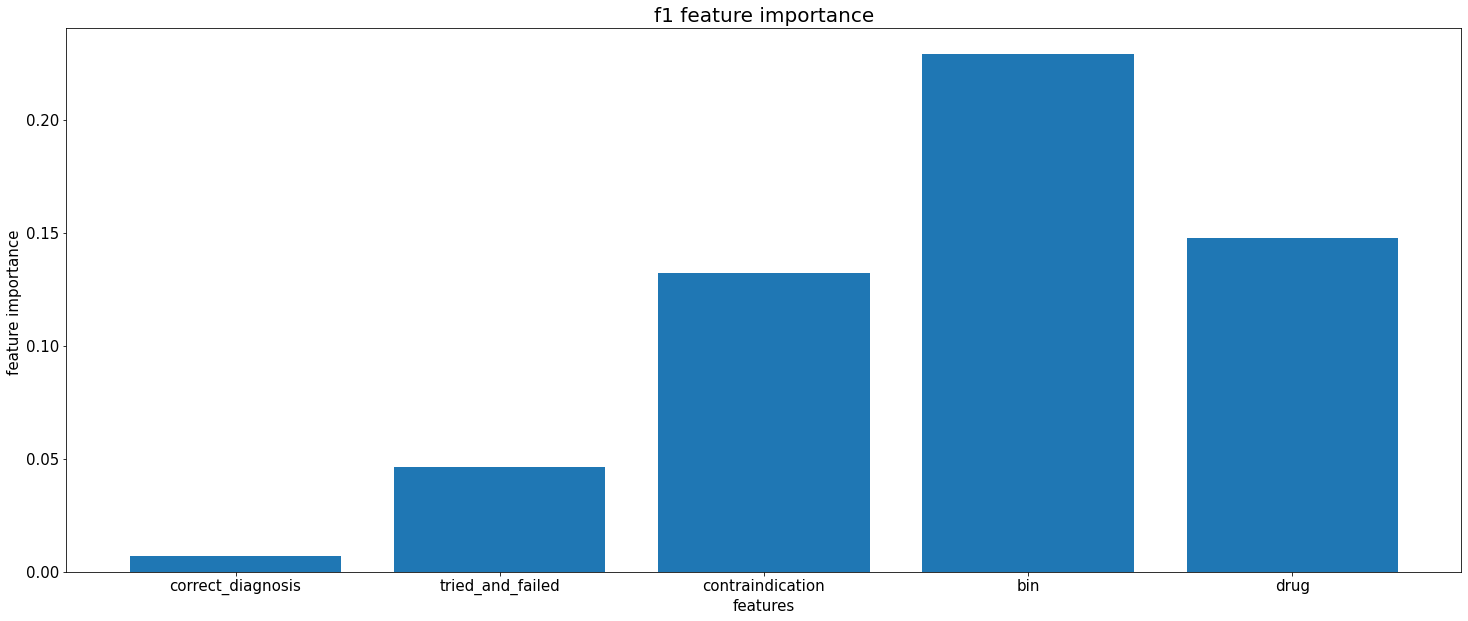



-roc_auc feature importance-

correct_diagnosis : 0.007
tried_and_failed : 0.046
contraindication : 0.132
bin : 0.229
drug : 0.15


double click the image to zoom in and out


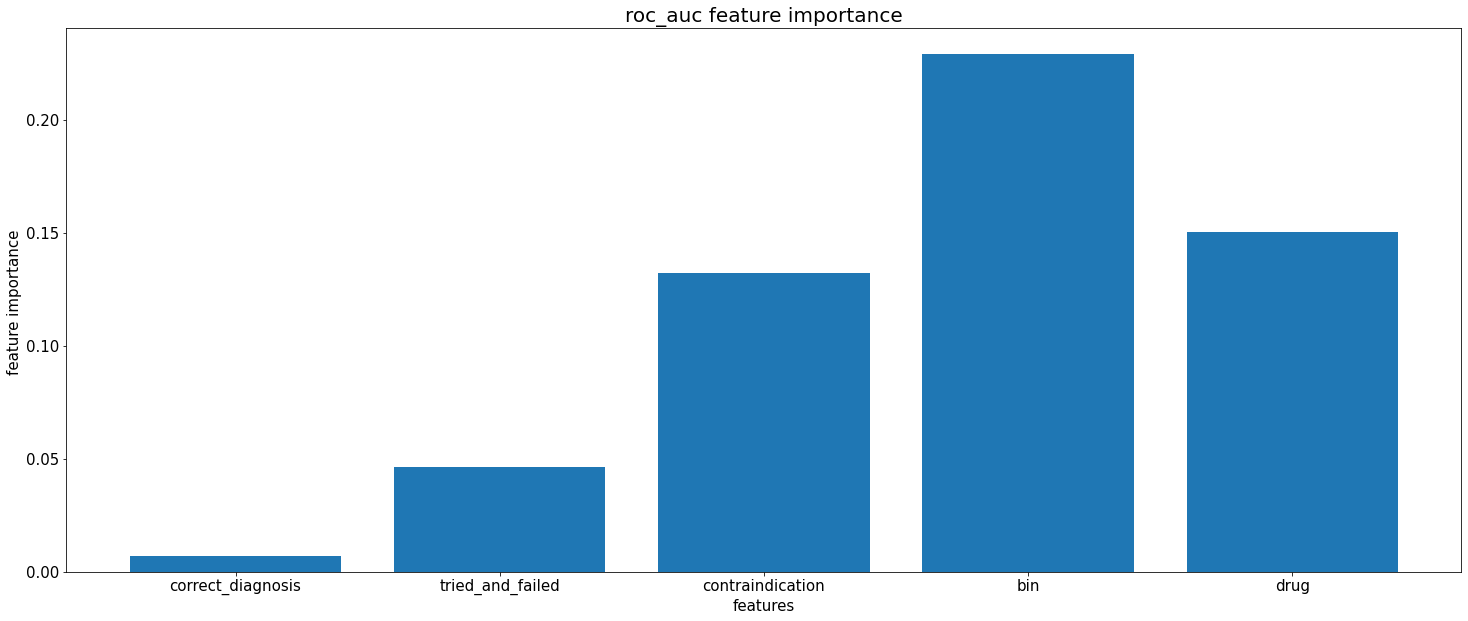

In [33]:
#summarize feature importances with respect to the accuracy_score feature
print('\033[1m'+'-accuracy_score feature importance-')
print('\033[0m')
for i in range(len(acs_importance)):
        print(features[i],':',round(acs_importance[i]/5,3))
# plot feature importances with respect to the accuracy_score feature
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('accuracy_score feature importance', fontsize = 20)
plt.bar(features, acs_importance/5)
plt.show()  


print()
print()


#summarize feature importances with respect to the precision feature
print('\033[1m'+'-precision feature importance-')
print('\033[0m')
for i in range(len(pre_importance)):
        print(features[i],':',round(pre_importance[i]/5,3))
# plot feature importances with respect to the precision feature
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('precision feature importance', fontsize = 20)
plt.bar(features, pre_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the true_positive_rate    
print('\033[1m'+'-true_positive_rate feature importance-')
print('\033[0m')
for i in range(len(tpr_importance)):
        print(features[i],':',round(tpr_importance[i]/5,3))
# plot feature importances with respect to the true_positive_rate
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('true_positive_rate feature importance', fontsize = 20)
plt.bar(features, tpr_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the false_positive_rate 
print('\033[1m'+'-false_positive_rate feature importance-')
print('\033[0m')
for i in range(len(fpr_importance)):
        print(features[i],':',round(fpr_importance[i]/5,3))
# plot feature importances with respect to the false_positive_rate
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('false_positive_rate feature importance', fontsize = 20)
plt.bar(features, fpr_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the f1   
print('\033[1m'+'-f1 feature importance-')
print('\033[0m')
for i in range(len(f1_importance)):
        print(features[i],':',round(f1_importance[i]/5,3))
# plot feature importances with respect to the f1
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('f1 feature importance', fontsize = 20)
plt.bar(features, f1_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the roc_auc
print('\033[1m'+'-roc_auc feature importance-')
print('\033[0m')
for i in range(len(auc_importance)):
        print(features[i],':',round(auc_importance[i]/5,3))
# plot feature importances with respect to the roc_auc
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('roc_auc feature importance', fontsize = 20)
plt.bar(features, auc_importance/5)
plt.show()

In [34]:
# key performance indicators
kpis.loc['DT','accuracy_score'] = round(np.mean(acses),3)
kpis.loc['DT','precision'] = round(np.mean(pres),3)
kpis.loc['DT','true_positive_rate'] = round(np.mean(tprs),3)
kpis.loc['DT','false_positive_rate'] = round(np.mean(fprs),3)
kpis.loc['DT','f1'] = round(np.mean(f1s),3)
kpis.loc['DT','roc_auc'] = round(np.mean(aucs),3)

In [35]:
kpis

,accuracy_score,precision,true_positive_rate,false_positive_rate,f1,roc_auc
Base,0.734,0.734,1.000,1.000,0.847,0.500
Log,0.815,0.832,0.938,0.524,0.882,0.879
LDA,0.784,0.793,1.000,1.000,0.866,0.721
SVM,0.515,0.727,0.538,0.549,0.611,0.468
DT,0.815,0.838,1.000,1.000,0.879,0.879
RF,0.000,0.000,0.000,0.000,0.000,0.000
XGB,0.000,0.000,0.000,0.000,0.000,0.000


### -Random Forest-

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
# cross validation key performance indicators
acses = np.zeros(5)
pres = np.zeros(5)
tprs = np.zeros(5)
fprs = np.zeros(5)
f1s = np.zeros(5)
aucs = np.zeros(5)
# feature importance scores
acs_importance = np.zeros(len(X_train.columns))
pre_importance = np.zeros(len(X_train.columns))
tpr_importance = np.zeros(len(X_train.columns))
fpr_importance = np.zeros(len(X_train.columns))
f1_importance = np.zeros(len(X_train.columns))
auc_importance = np.zeros(len(X_train.columns))

In [38]:
# cross validation computing key performance indicators
i=0
for train_index, test_index in kfold.split(X_train, y_train) :
    X_tt = X_train.iloc[train_index, :].copy()
    X_ho = X_train.iloc[test_index, :].copy()
    y_tt = y_train.iloc[train_index].copy()
    y_ho = y_train.iloc[test_index].copy()
    
    # accuracy_score
    rf = RandomForestClassifier(n_estimators = 100,
                            max_depth = paras.loc['RF','accuracy_score']['max_depth'],
                            random_state = 623)
    rf.fit(X_tt.values,y_tt.values)
    pred = rf.predict(X_ho.values)  
    acses[i] = accuracy_score(y_ho.values, pred)
    acs_importance = acs_importance + rf.feature_importances_
    
    # precision
    rf = RandomForestClassifier(n_estimators = 100,
                            max_depth = paras.loc['RF','precision']['max_depth'],
                            random_state = 623)
    rf.fit(X_tt.values,y_tt.values)
    pred = rf.predict(X_ho.values)    
    pres[i] = precision_score(y_ho.values, pred)
    pre_importance = pre_importance + rf.feature_importances_
    
    # true_positive_rate
    rf = RandomForestClassifier(n_estimators = 100,
                            max_depth = paras.loc['RF','true_positive_rate']['max_depth'],
                            random_state = 623)
    rf.fit(X_tt.values,y_tt.values)
    pred = rf.predict(X_ho.values)
    conf_mat = confusion_matrix(y_ho, pred)
    tprs[i] = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1]) 
    tpr_importance = tpr_importance + rf.feature_importances_
    
    # false_positive_rate
    rf = RandomForestClassifier(n_estimators = 100,
                            max_depth = paras.loc['RF','false_positive_rate']['max_depth'],
                            random_state = 623)
    rf.fit(X_tt.values,y_tt.values)
    pred = rf.predict(X_ho.values)
    conf_mat = confusion_matrix(y_ho, pred)
    fprs[i] = conf_mat[0,1]/(conf_mat[0,0] + conf_mat[0,1])
    fpr_importance = fpr_importance + rf.feature_importances_
    
    # f1
    rf = RandomForestClassifier(n_estimators = 100,
                            max_depth = paras.loc['RF','f1']['max_depth'],
                            random_state = 623)
    rf.fit(X_tt.values,y_tt.values)
    pred = rf.predict(X_ho.values)    
    f1s[i] = f1_score(y_ho.values, pred)
    f1_importance = f1_importance + rf.feature_importances_
    
    # roc_auc
    rf = RandomForestClassifier(n_estimators = 100,
                            max_depth = paras.loc['RF','roc_auc']['max_depth'],
                            random_state = 623)
    rf.fit(X_tt.values,y_tt.values)
    pred_proba = rf.predict_proba(X_ho.values)[:,1]
    aucs[i] = roc_auc_score(y_ho.values, pred_proba)
    auc_importance = auc_importance + rf.feature_importances_
    i=i+1

-accuracy_score feature importance-

correct_diagnosis : 0.004
tried_and_failed : 0.048
contraindication : 0.157
417380 : 0.123
417614 : 0.103
417740 : 0.102
999001 : 0.059
A : 0.115
B : 0.129
C : 0.159


double click the image to zoom in and out


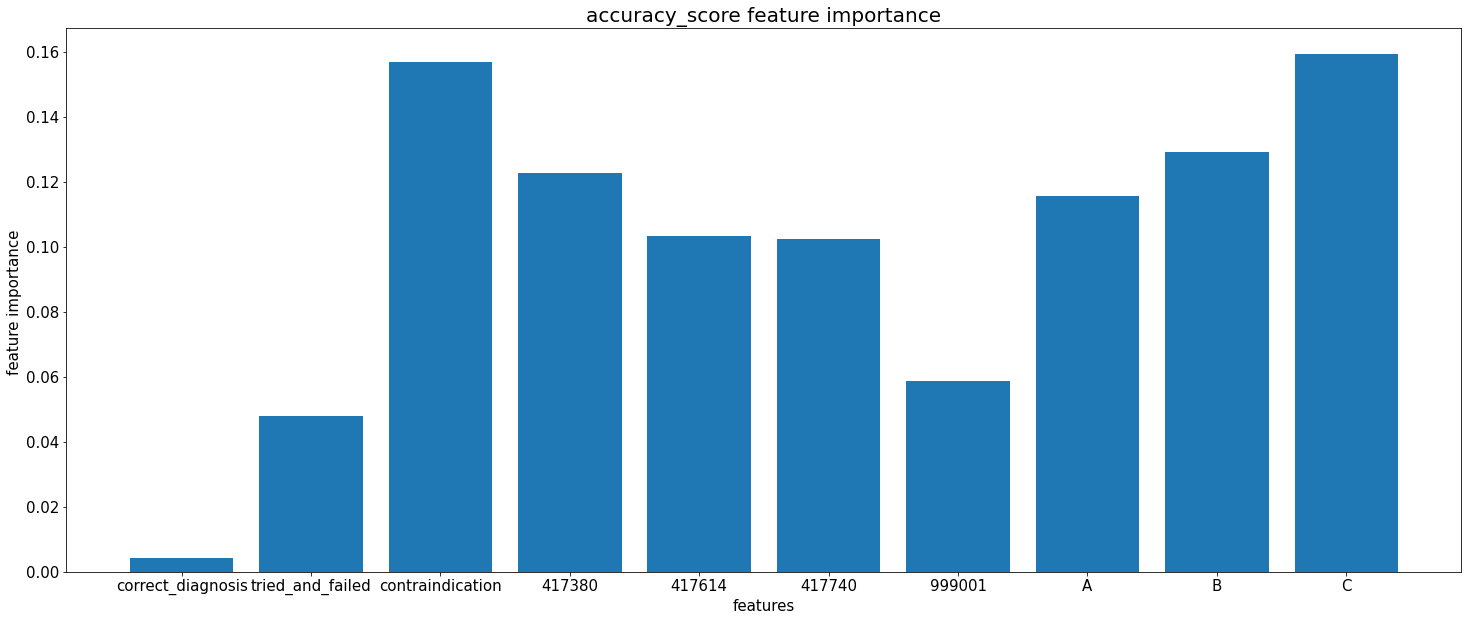



-precision feature importance-

correct_diagnosis : 0.004
tried_and_failed : 0.048
contraindication : 0.157
417380 : 0.123
417614 : 0.103
417740 : 0.102
999001 : 0.059
A : 0.115
B : 0.129
C : 0.159


double click the image to zoom in and out


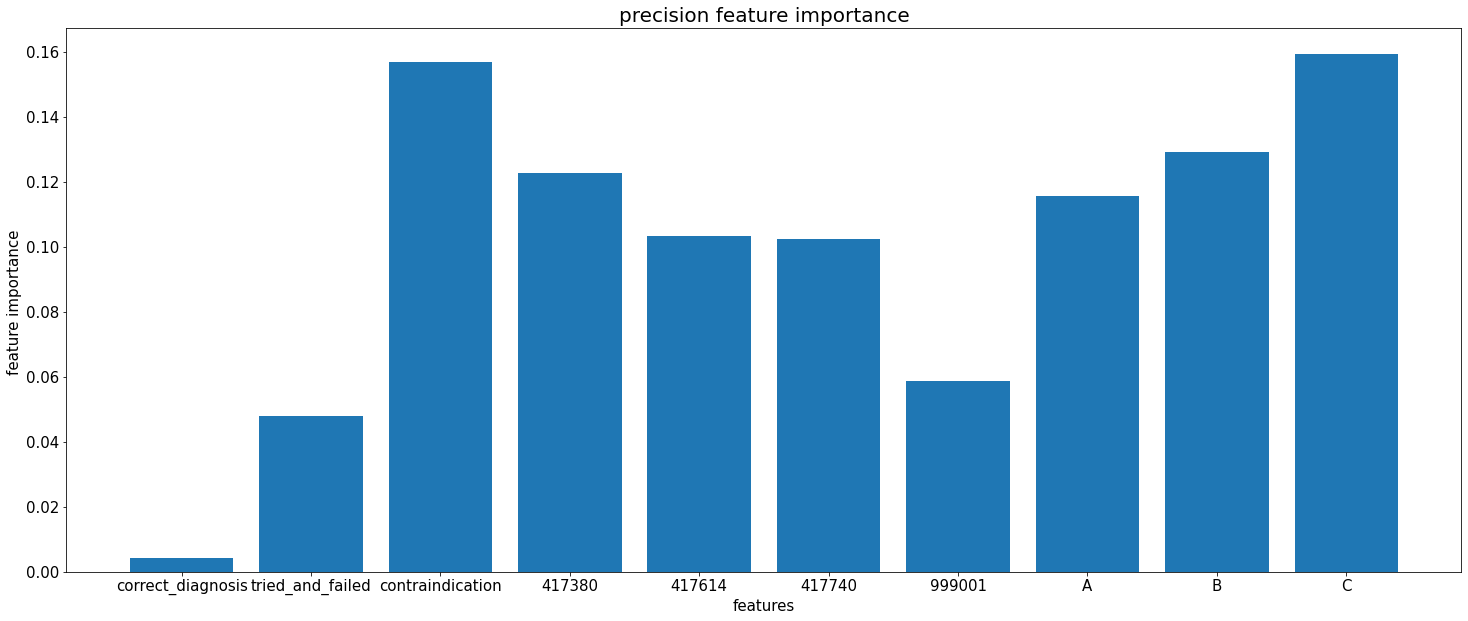



-true_positive_rate feature importance-

correct_diagnosis : 0.003
tried_and_failed : 0.097
contraindication : 0.305
417380 : 0.099
417614 : 0.05
417740 : 0.075
999001 : 0.153
A : 0.059
B : 0.064
C : 0.095


double click the image to zoom in and out


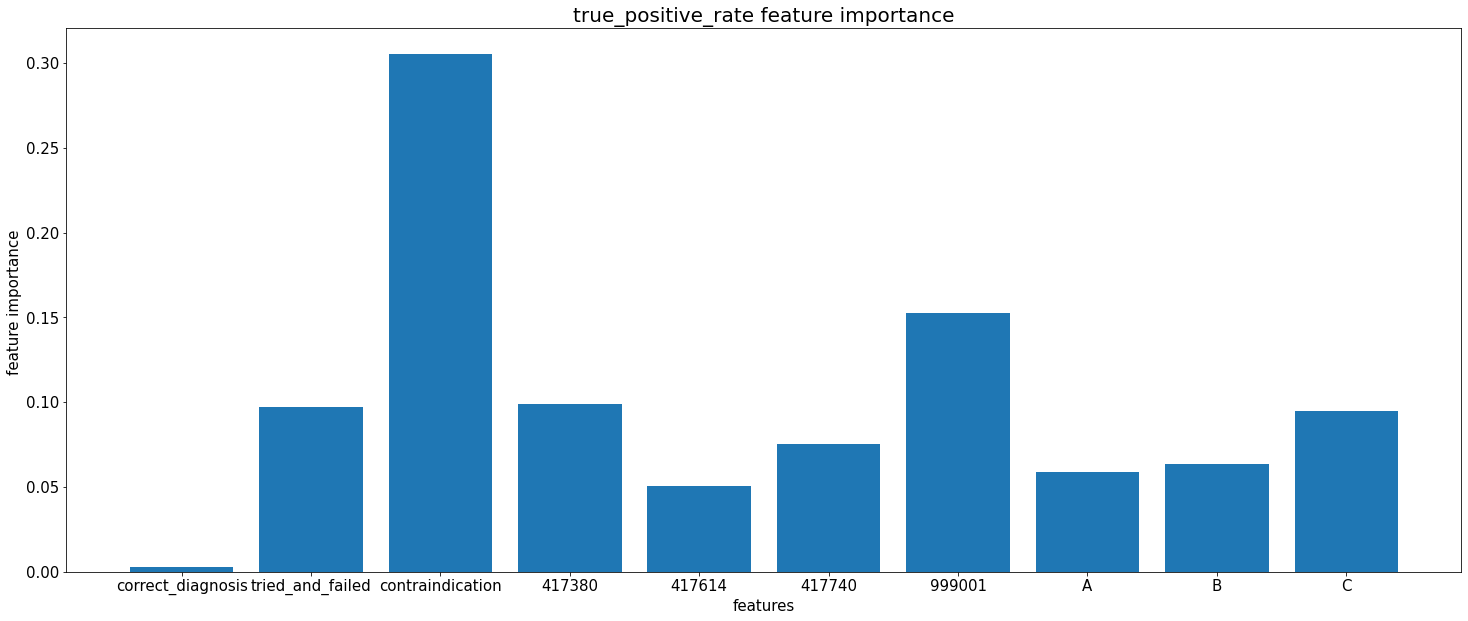



-false_positive_rate feature importance-

correct_diagnosis : 0.003
tried_and_failed : 0.097
contraindication : 0.305
417380 : 0.099
417614 : 0.05
417740 : 0.075
999001 : 0.153
A : 0.059
B : 0.064
C : 0.095


double click the image to zoom in and out


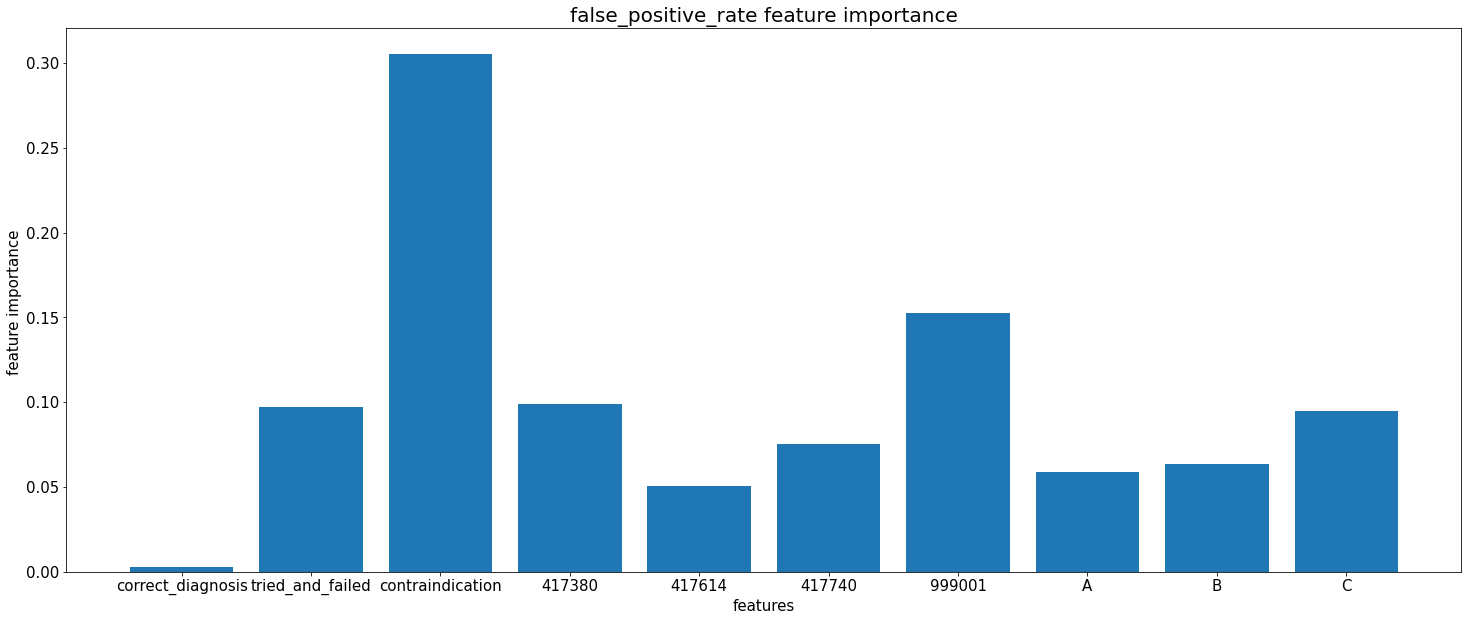



-f1 feature importance-

correct_diagnosis : 0.004
tried_and_failed : 0.048
contraindication : 0.157
417380 : 0.123
417614 : 0.103
417740 : 0.102
999001 : 0.059
A : 0.115
B : 0.129
C : 0.159


double click the image to zoom in and out


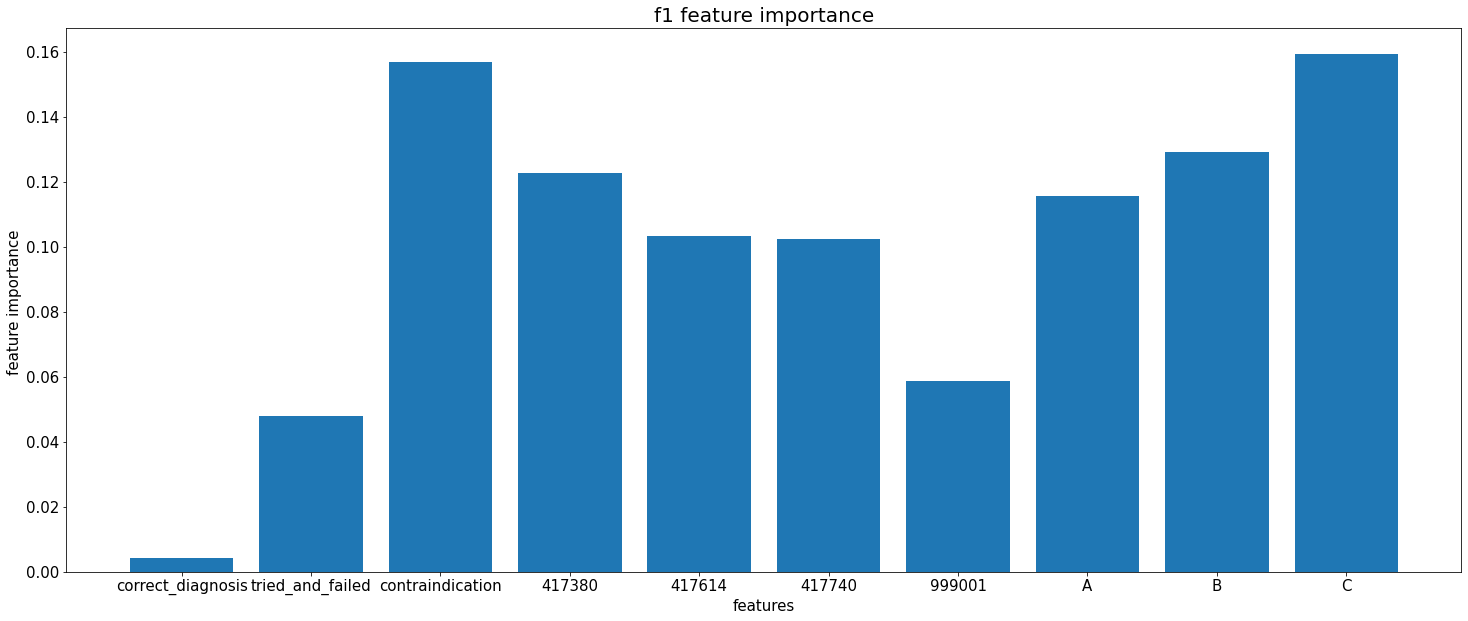



-roc_auc feature importance-

correct_diagnosis : 0.004
tried_and_failed : 0.048
contraindication : 0.157
417380 : 0.123
417614 : 0.103
417740 : 0.102
999001 : 0.059
A : 0.115
B : 0.129
C : 0.159


double click the image to zoom in and out


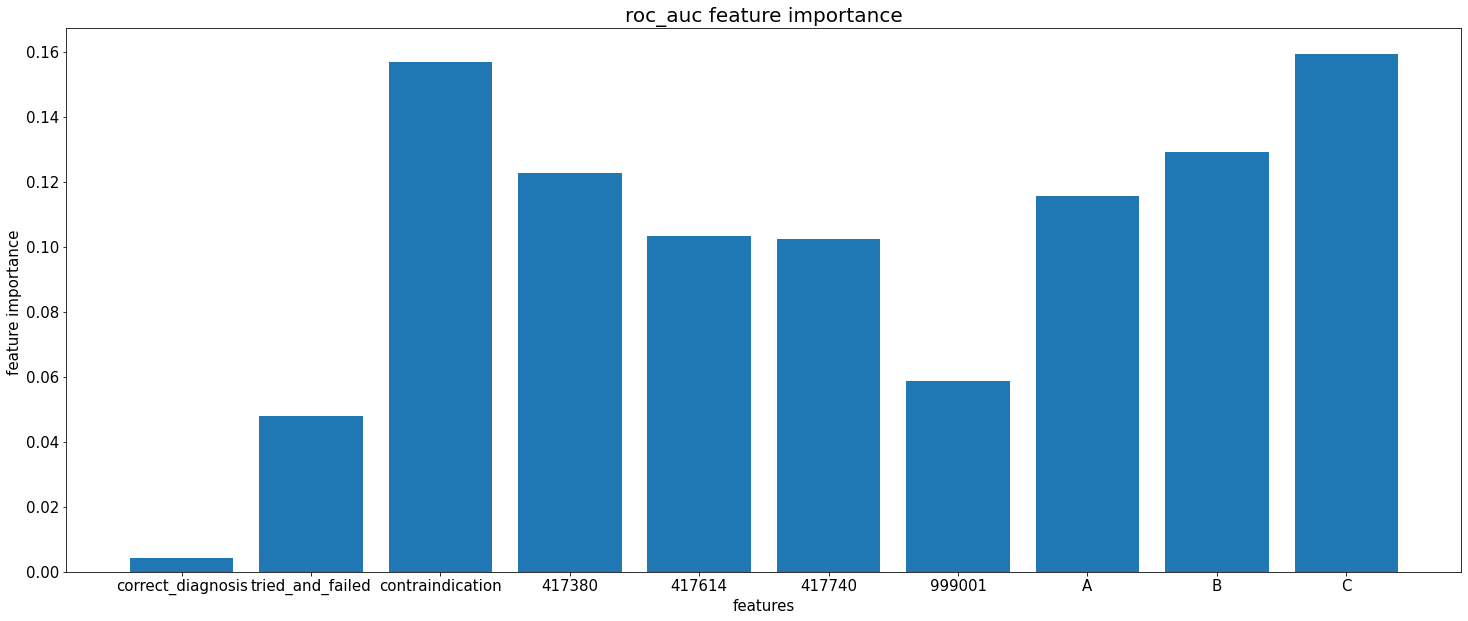

In [39]:
#summarize feature importances with respect to the accuracy_score
print('\033[1m'+'-accuracy_score feature importance-')
print('\033[0m')
for i in range(len(acs_importance)):
        print(X_train.columns[i],':',round(acs_importance[i]/5,3))
# plot feature importances with respect to the accuracy_score
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('accuracy_score feature importance', fontsize = 20)
plt.bar([x for x in X_pre.columns], acs_importance/5)
plt.show()  


print()
print()


#summarize feature importances with respect to the precision
print('\033[1m'+'-precision feature importance-')
print('\033[0m')
for i in range(len(pre_importance)):
        print(X_train.columns[i],':',round(pre_importance[i]/5,3))
# plot feature importances with respect to the precision
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('precision feature importance', fontsize = 20)
plt.bar([x for x in X_pre.columns], pre_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the true_positive_rate    
print('\033[1m'+'-true_positive_rate feature importance-')
print('\033[0m')
for i in range(len(tpr_importance)):
        print(X_train.columns[i],':',round(tpr_importance[i]/5,3))
# plot feature importances with respect to the true_positive_rate
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('true_positive_rate feature importance', fontsize = 20)
plt.bar([x for x in X_pre.columns], tpr_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the false_positive_rate 
print('\033[1m'+'-false_positive_rate feature importance-')
print('\033[0m')
for i in range(len(fpr_importance)):
        print(X_train.columns[i],':',round(fpr_importance[i]/5,3))
# plot false_positive_rate
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('false_positive_rate feature importance', fontsize = 20)
plt.bar([x for x in X_pre.columns], fpr_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the f1   
print('\033[1m'+'-f1 feature importance-')
print('\033[0m')
for i in range(len(f1_importance)):
        print(X_train.columns[i],':',round(f1_importance[i]/5,3))
# plot feature importances with respect to the f1
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('f1 feature importance', fontsize = 20)
plt.bar([x for x in X_pre.columns], f1_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the roc_auc
print('\033[1m'+'-roc_auc feature importance-')
print('\033[0m')
for i in range(len(auc_importance)):
        print(X_train.columns[i],':',round(auc_importance[i]/5,3))
# plot feature importances with respect to the roc_auc
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('roc_auc feature importance', fontsize = 20)
plt.bar([x for x in X_pre.columns], auc_importance/5)
plt.show()    

In [40]:
X_train.columns

Index(['correct_diagnosis', 'tried_and_failed', 'contraindication', '417380',
       '417614', '417740', '999001', 'A', 'B', 'C'],
      dtype='object')

In [41]:
# accuracy_score
acs_importance[3] = max(acs_importance[3:7])
acs_importance[4] = max(acs_importance[7:])
acs_importance = acs_importance[:5]
# precision
pre_importance[3] = max(pre_importance[3:7])
pre_importance[4] = max(pre_importance[7:])
pre_importance = pre_importance[:5]
# true_positive_rate
tpr_importance[3] = max(tpr_importance[3:7])
tpr_importance[4] = max(tpr_importance[7:])
tpr_importance = tpr_importance[:5]
# false_positive_rate
fpr_importance[3] = max(fpr_importance[3:7])
fpr_importance[4] = max(fpr_importance[7:])
fpr_importance = fpr_importance[:5]
# f1
f1_importance[3] = max(f1_importance[3:7])
f1_importance[4] = max(f1_importance[7:])
f1_importance = f1_importance[:5]
# roc_auc
auc_importance[3] = max(auc_importance[3:7])
auc_importance[4] = max(auc_importance[7:])
auc_importance = auc_importance[:5]

In [42]:
features = list(X_train.columns.copy())
features[3] = 'bin'
features[4] = 'drug'
features = features[:5]
features

['correct_diagnosis', 'tried_and_failed', 'contraindication', 'bin', 'drug']

-accuracy_score feature importance-

correct_diagnosis : 0.004
tried_and_failed : 0.048
contraindication : 0.157
bin : 0.123
drug : 0.159


double click the image to zoom in and out


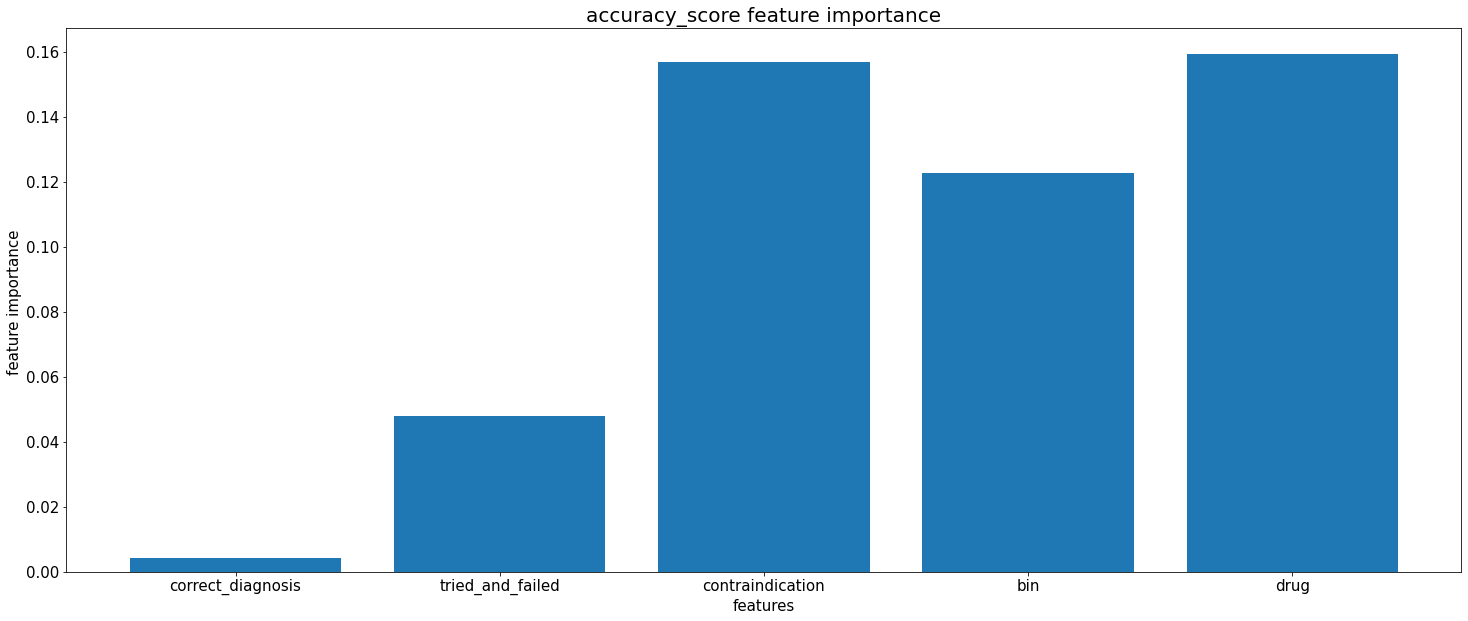



-precision feature importance-

correct_diagnosis : 0.004
tried_and_failed : 0.048
contraindication : 0.157
bin : 0.123
drug : 0.159


double click the image to zoom in and out


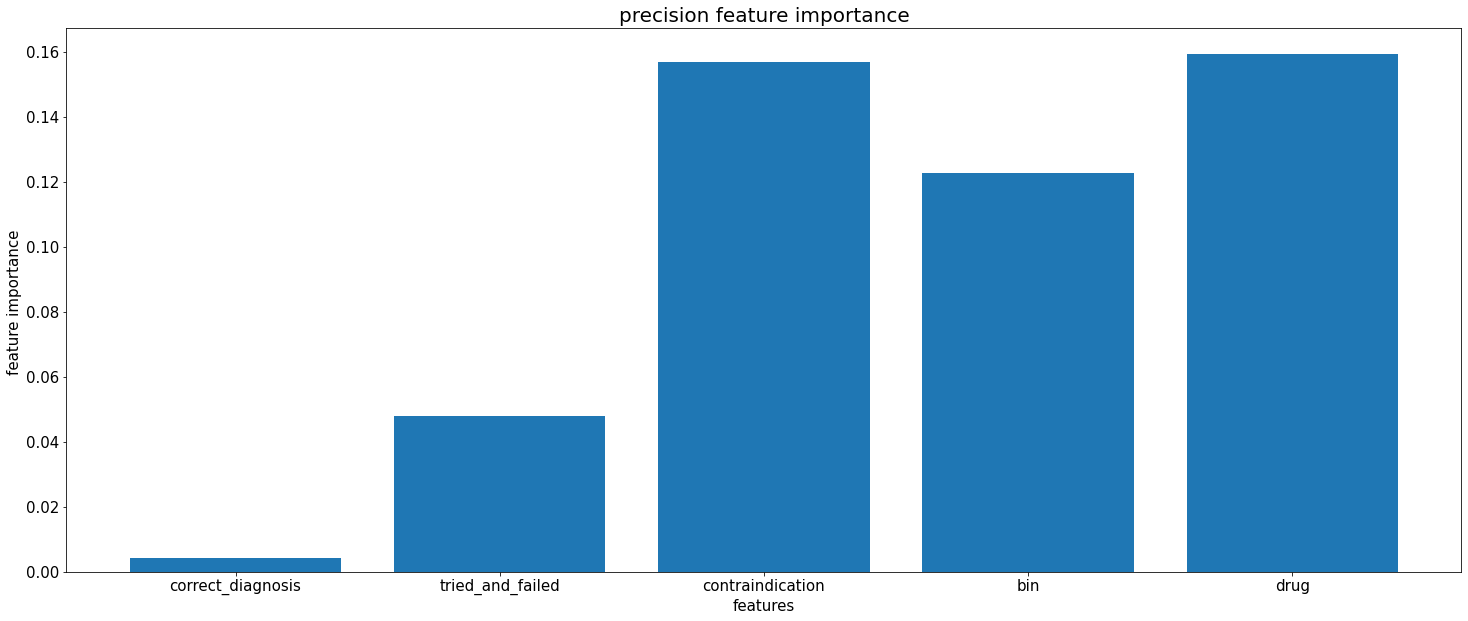



-true_positive_rate feature importance-

correct_diagnosis : 0.003
tried_and_failed : 0.097
contraindication : 0.305
bin : 0.153
drug : 0.095


double click the image to zoom in and out


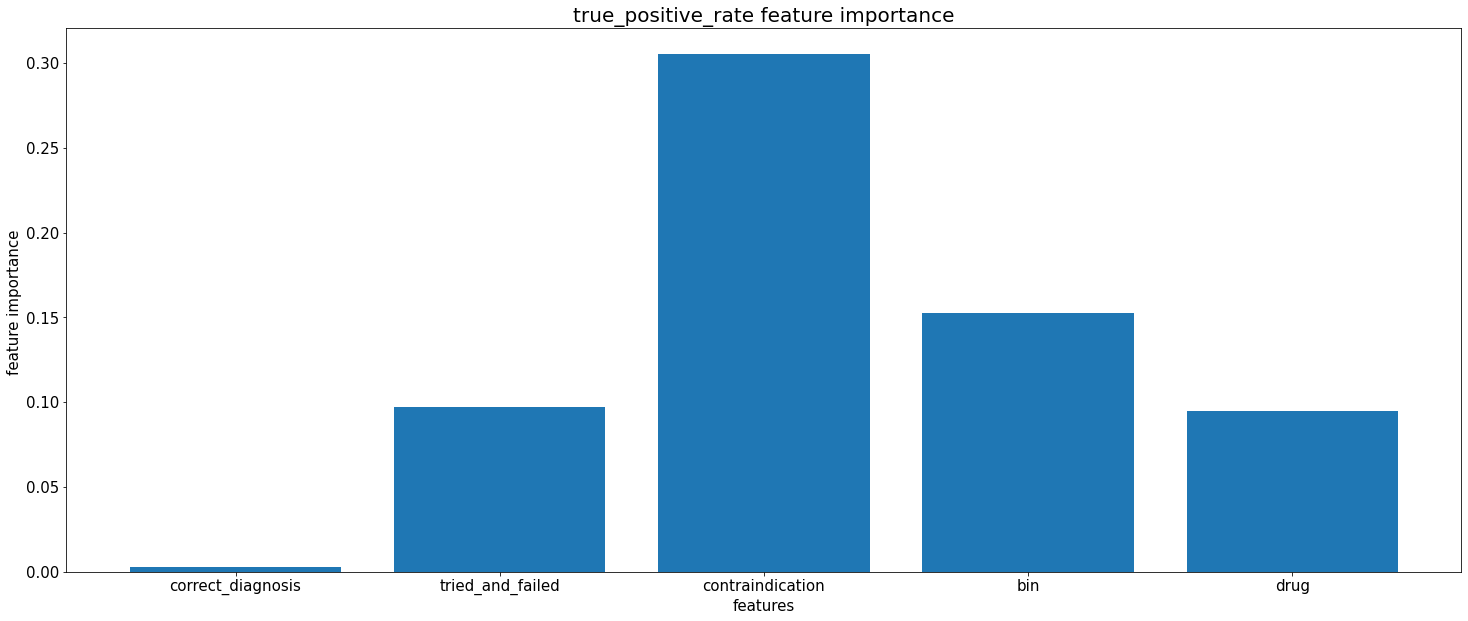



-false_positive_rate feature importance-

correct_diagnosis : 0.003
tried_and_failed : 0.097
contraindication : 0.305
bin : 0.153
drug : 0.095


double click the image to zoom in and out


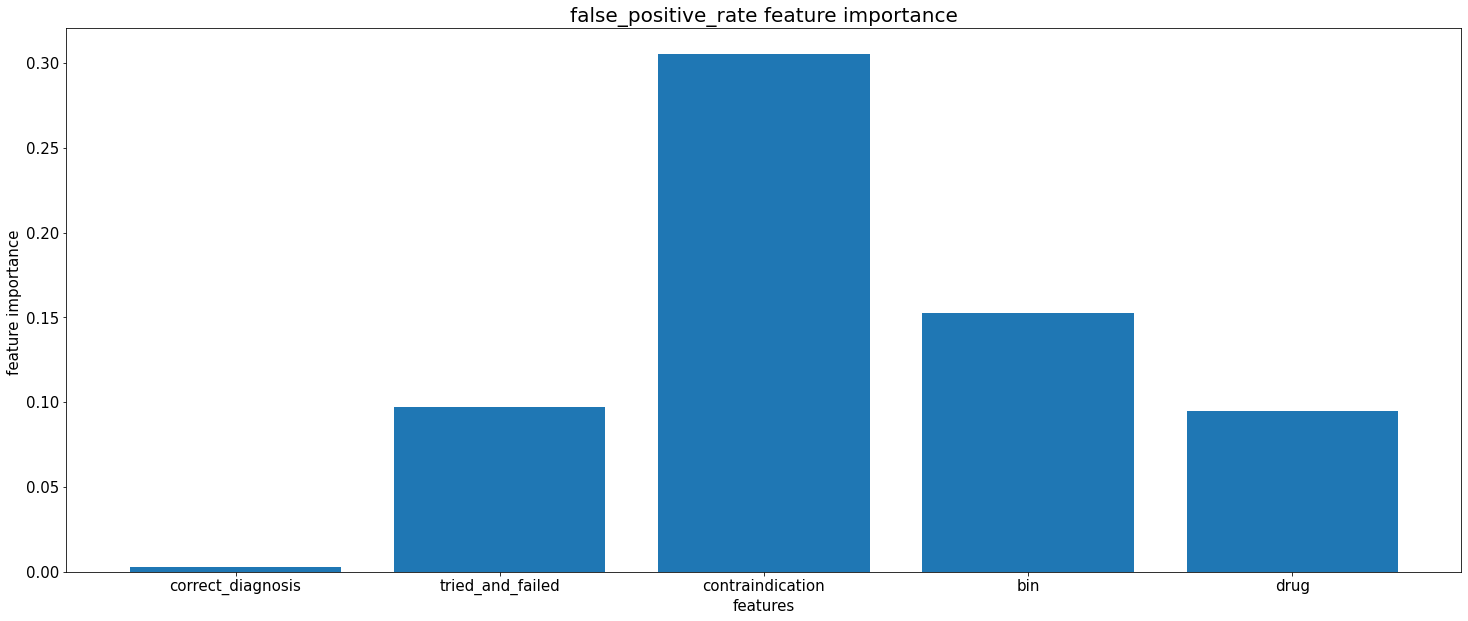



-f1 feature importance-

correct_diagnosis : 0.004
tried_and_failed : 0.048
contraindication : 0.157
bin : 0.123
drug : 0.159


double click the image to zoom in and out


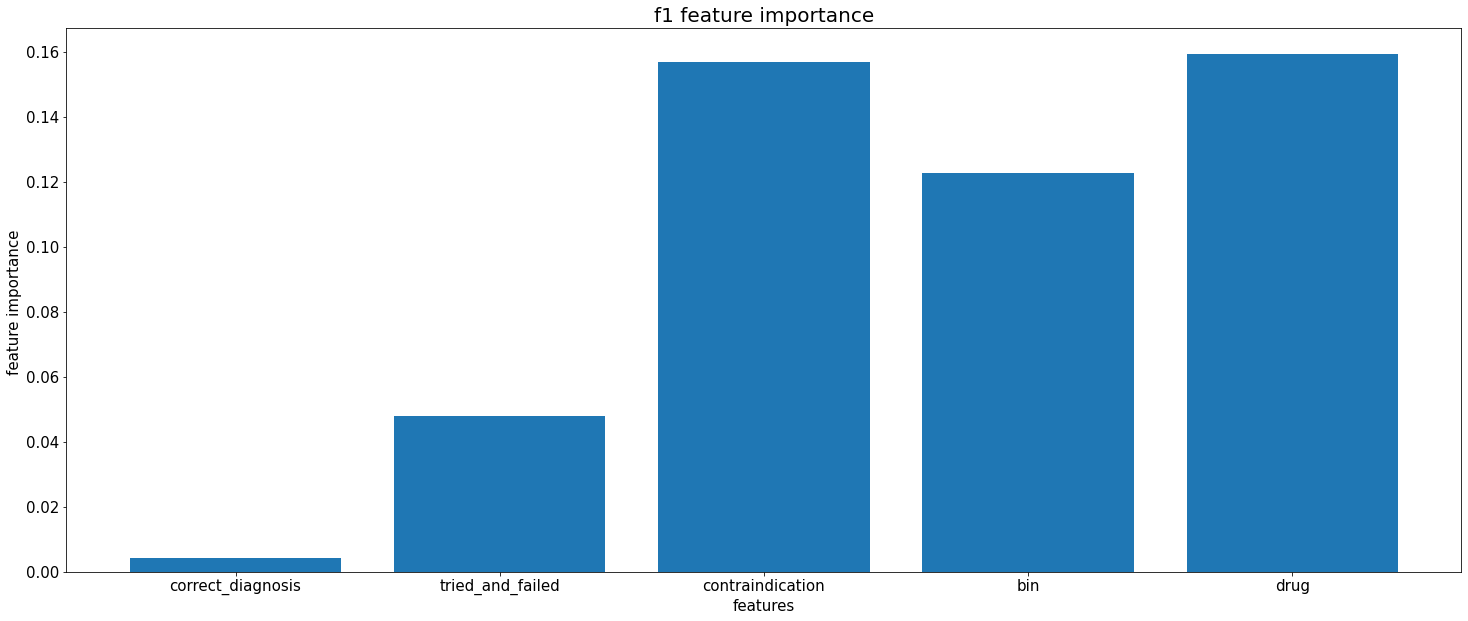



-roc_auc feature importance-

correct_diagnosis : 0.004
tried_and_failed : 0.048
contraindication : 0.157
bin : 0.123
drug : 0.159


double click the image to zoom in and out


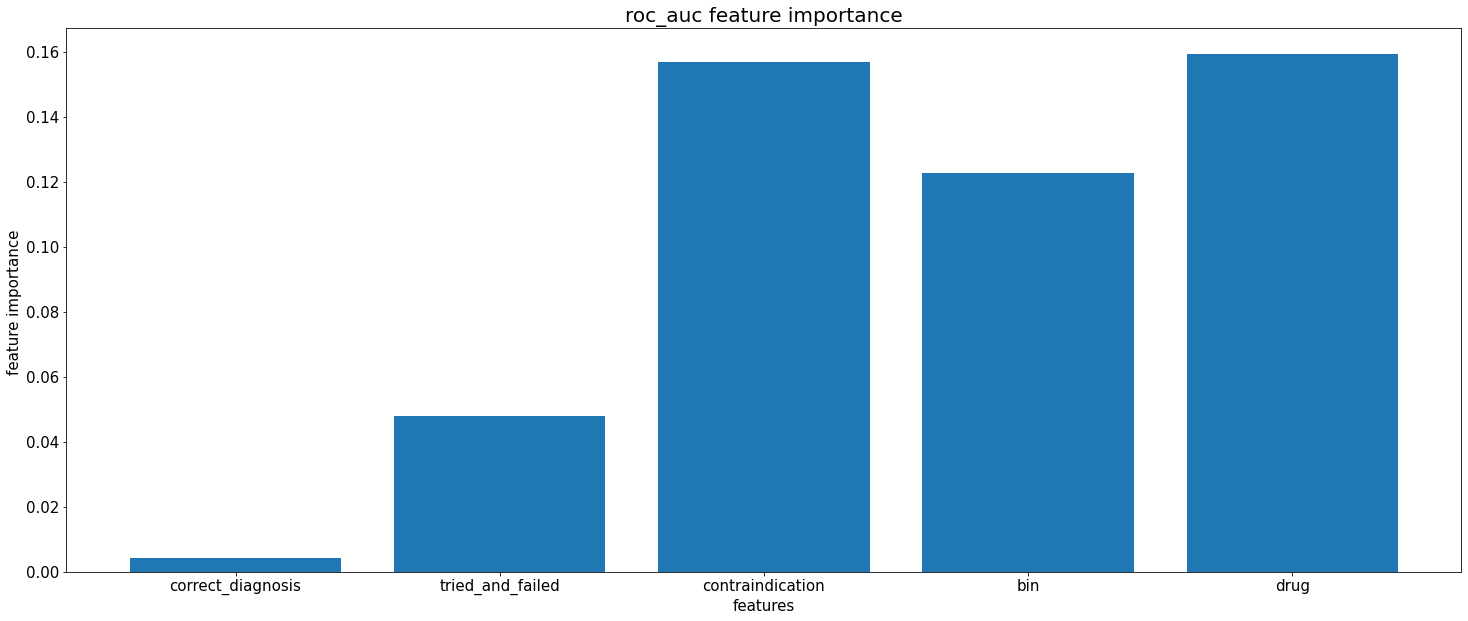

In [43]:
#summarize feature importances with respect to the accuracy_score
print('\033[1m'+'-accuracy_score feature importance-')
print('\033[0m')
for i in range(len(acs_importance)):
        print(features[i],':',round(acs_importance[i]/5,3))
# plot feature importances with respect to the accuracy_score
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('accuracy_score feature importance', fontsize = 20)
plt.bar(features, acs_importance/5)
plt.show()  


print()
print()


#summarize feature importances with respect to the precision
print('\033[1m'+'-precision feature importance-')
print('\033[0m')
for i in range(len(pre_importance)):
        print(features[i],':',round(pre_importance[i]/5,3))
# plot feature importances with respect to the precision
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('precision feature importance', fontsize = 20)
plt.bar(features, pre_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the true_positive_rate    
print('\033[1m'+'-true_positive_rate feature importance-')
print('\033[0m')
for i in range(len(tpr_importance)):
        print(features[i],':',round(tpr_importance[i]/5,3))
# plot feature importances with respect to the true_positive_rate
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('true_positive_rate feature importance', fontsize = 20)
plt.bar(features, tpr_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the false_positive_rate 
print('\033[1m'+'-false_positive_rate feature importance-')
print('\033[0m')
for i in range(len(fpr_importance)):
        print(features[i],':',round(fpr_importance[i]/5,3))
# plot feature importances with respect to the false_positive_rate
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('false_positive_rate feature importance', fontsize = 20)
plt.bar(features, fpr_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the f1   
print('\033[1m'+'-f1 feature importance-')
print('\033[0m')
for i in range(len(f1_importance)):
        print(features[i],':',round(f1_importance[i]/5,3))
# plot feature importances with respect to the f1
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('f1 feature importance', fontsize = 20)
plt.bar(features, f1_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the roc_auc
print('\033[1m'+'-roc_auc feature importance-')
print('\033[0m')
for i in range(len(auc_importance)):
        print(features[i],':',round(auc_importance[i]/5,3))
# plot feature importances with respect to the roc_auc
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('roc_auc feature importance', fontsize = 20)
plt.bar(features, auc_importance/5)
plt.show()    

In [44]:
# key performance indicators
kpis.loc['RF','accuracy_score'] = round(np.mean(acses),3)
kpis.loc['RF','precision'] = round(np.mean(pres),3)
kpis.loc['RF','true_positive_rate'] = round(np.mean(tprs),3)
kpis.loc['RF','false_positive_rate'] = round(np.mean(fprs),3)
kpis.loc['RF','f1'] = round(np.mean(f1s),3)
kpis.loc['RF','roc_auc'] = round(np.mean(aucs),3)

In [45]:
kpis

,accuracy_score,precision,true_positive_rate,false_positive_rate,f1,roc_auc
Base,0.734,0.734,1.000,1.000,0.847,0.500
Log,0.815,0.832,0.938,0.524,0.882,0.879
LDA,0.784,0.793,1.000,1.000,0.866,0.721
SVM,0.515,0.727,0.538,0.549,0.611,0.468
DT,0.815,0.838,1.000,1.000,0.879,0.879
RF,0.815,0.831,0.999,0.944,0.882,0.878
XGB,0.000,0.000,0.000,0.000,0.000,0.000


### -XGBoost-

In [46]:
from xgboost import XGBClassifier

In [47]:
# cross validation key performance indicators
acses = np.zeros(5)
pres = np.zeros(5)
tprs = np.zeros(5)
fprs = np.zeros(5)
f1s = np.zeros(5)
aucs = np.zeros(5)
# feature importance scores
acs_importance = np.zeros(len(X_train.columns))
pre_importance = np.zeros(len(X_train.columns))
tpr_importance = np.zeros(len(X_train.columns))
fpr_importance = np.zeros(len(X_train.columns))
f1_importance = np.zeros(len(X_train.columns))
auc_importance = np.zeros(len(X_train.columns))

In [48]:
# cross validation computing key performance indicators
i=0
for train_index, test_index in kfold.split(X_train, y_train) : 
    X_tt = X_train.iloc[train_index, :].copy()
    X_ho = X_train.iloc[test_index, :].copy()
    y_tt = y_train.iloc[train_index].copy()
    y_ho = y_train.iloc[test_index].copy()
    
    # accuracy_score
    xgb = XGBClassifier(learning_rate = paras.loc['XGB','accuracy_score']['learning_rate'],
                    max_depth = paras.loc['XGB','accuracy_score']['max_depth'],
                    use_label_encoder=False,
                    n_estimators = 100,
                    random_state = 623,
                    eval_metric = 'logloss')
    xgb.fit(X_tt.values, y_tt.values,
            early_stopping_rounds = 3,
            eval_set = [(X_ho.values, y_ho.values)])
    pred = xgb.predict(X_ho.values)
    acses[i] = accuracy_score(y_ho, pred)
    acs_importance = acs_importance + xgb.feature_importances_
    
    # precision
    xgb = XGBClassifier(learning_rate = paras.loc['XGB','precision']['learning_rate'],
                    max_depth = paras.loc['XGB','precision']['max_depth'],
                    use_label_encoder=False,
                    n_estimators = 100,
                    random_state = 623,
                    eval_metric = 'logloss')
    xgb.fit(X_tt.values, y_tt.values,
            early_stopping_rounds = 3,
            eval_set = [(X_ho.values, y_ho.values)])
    pred = xgb.predict(X_ho.values)        
    pres[i] = precision_score(y_ho, pred)
    pre_importance = pre_importance + xgb.feature_importances_
    
    # true_positive_rate
    xgb = XGBClassifier(learning_rate = paras.loc['XGB','true_positive_rate']['learning_rate'],
                    max_depth = paras.loc['XGB','true_positive_rate']['max_depth'],
                    use_label_encoder=False,
                    n_estimators = 100,
                    random_state = 623,
                    eval_metric = 'logloss')
    xgb.fit(X_tt.values, y_tt.values,
            early_stopping_rounds = 3,
            eval_set = [(X_ho.values, y_ho.values)])
    pred = xgb.predict(X_ho.values)         
    conf_mat = confusion_matrix(y_ho, pred)
    tprs[i] = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1]) 
    tpr_importance = tpr_importance + xgb.feature_importances_
    
    # false_positive_rate
    xgb = XGBClassifier(learning_rate = paras.loc['XGB','false_positive_rate']['learning_rate'],
                    max_depth = paras.loc['XGB','false_positive_rate']['max_depth'],
                    use_label_encoder=False,
                    n_estimators = 100,
                    random_state = 623,
                    eval_metric = 'logloss')
    xgb.fit(X_tt.values, y_tt.values,
            early_stopping_rounds = 3,
            eval_set = [(X_ho.values, y_ho.values)])
    pred = xgb.predict(X_ho.values)
    conf_mat = confusion_matrix(y_ho, pred)
    fprs[i] = conf_mat[0,1]/(conf_mat[0,0] + conf_mat[0,1])
    fpr_importance = fpr_importance + xgb.feature_importances_
    
    # f1
    xgb = XGBClassifier(learning_rate = paras.loc['XGB','f1']['learning_rate'],
                    max_depth = paras.loc['XGB','f1']['max_depth'],
                    use_label_encoder=False,
                    n_estimators = 100,
                    random_state = 623,
                    eval_metric = 'logloss')
    xgb.fit(X_tt.values, y_tt.values,
            early_stopping_rounds = 3,
            eval_set = [(X_ho.values, y_ho.values)])
    pred = xgb.predict(X_ho.values)         
    f1s[i] = f1_score(y_ho, pred)
    f1_importance = f1_importance + xgb.feature_importances_
    
    # roc_auc
    xgb = XGBClassifier(learning_rate = paras.loc['XGB','roc_auc']['learning_rate'],
                    max_depth = paras.loc['XGB','roc_auc']['max_depth'],
                    use_label_encoder=False,
                    n_estimators = 100,
                    random_state = 623,
                    eval_metric = 'logloss')
    xgb.fit(X_tt.values, y_tt.values,
            early_stopping_rounds = 3,
            eval_set = [(X_ho.values, y_ho.values)])
    pred_proba = xgb.predict_proba(X_ho.values)[:,1]         
    aucs[i] = roc_auc_score(y_ho, pred_proba)
    auc_importance = auc_importance + xgb.feature_importances_
    i=i+1

[0]	validation_0-logloss:0.51941
[1]	validation_0-logloss:0.43831
[2]	validation_0-logloss:0.38988
[3]	validation_0-logloss:0.37720
[4]	validation_0-logloss:0.37469
[5]	validation_0-logloss:0.37215
[6]	validation_0-logloss:0.37139
[7]	validation_0-logloss:0.37085
[8]	validation_0-logloss:0.37023
[9]	validation_0-logloss:0.37008
[10]	validation_0-logloss:0.37008
[11]	validation_0-logloss:0.36982
[12]	validation_0-logloss:0.36955
[13]	validation_0-logloss:0.36941
[14]	validation_0-logloss:0.36945
[15]	validation_0-logloss:0.36932
[16]	validation_0-logloss:0.36908
[17]	validation_0-logloss:0.36917
[18]	validation_0-logloss:0.36914
[19]	validation_0-logloss:0.36919
[0]	validation_0-logloss:0.68805
[1]	validation_0-logloss:0.68307
[2]	validation_0-logloss:0.67818
[3]	validation_0-logloss:0.67339
[4]	validation_0-logloss:0.66869
[5]	validation_0-logloss:0.66407
[6]	validation_0-logloss:0.65955
[7]	validation_0-logloss:0.65511
[8]	validation_0-logloss:0.65075
[9]	validation_0-logloss:0.64648


-accuracy_score feature importance-

correct_diagnosis : 0.011
tried_and_failed : 0.03
contraindication : 0.076
417380 : 0.049
417614 : 0.119
417740 : 0.046
999001 : 0.054
A : 0.2
B : 0.289
C : 0.125


double click the image to zoom in and out


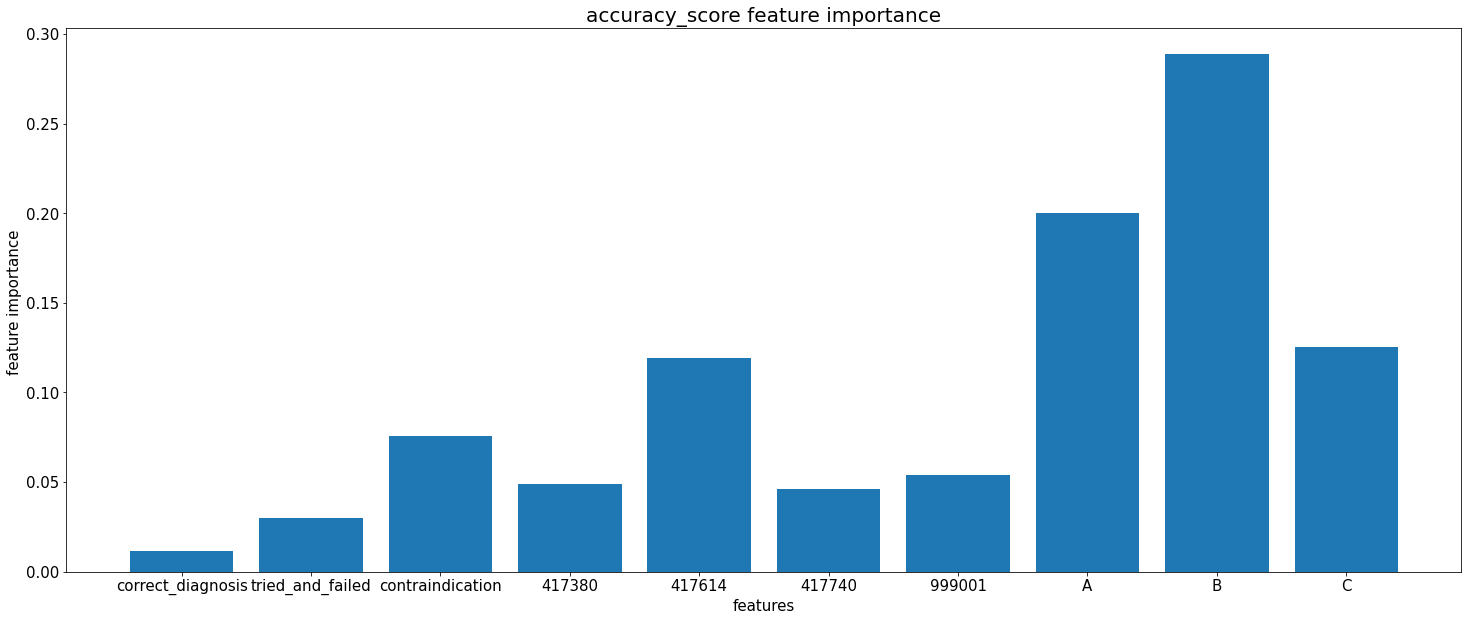



-precision feature importance-

correct_diagnosis : 0.001
tried_and_failed : 0.01
contraindication : 0.359
417380 : 0.122
417614 : 0.067
417740 : 0.125
999001 : 0.094
A : 0.054
B : 0.06
C : 0.108


double click the image to zoom in and out


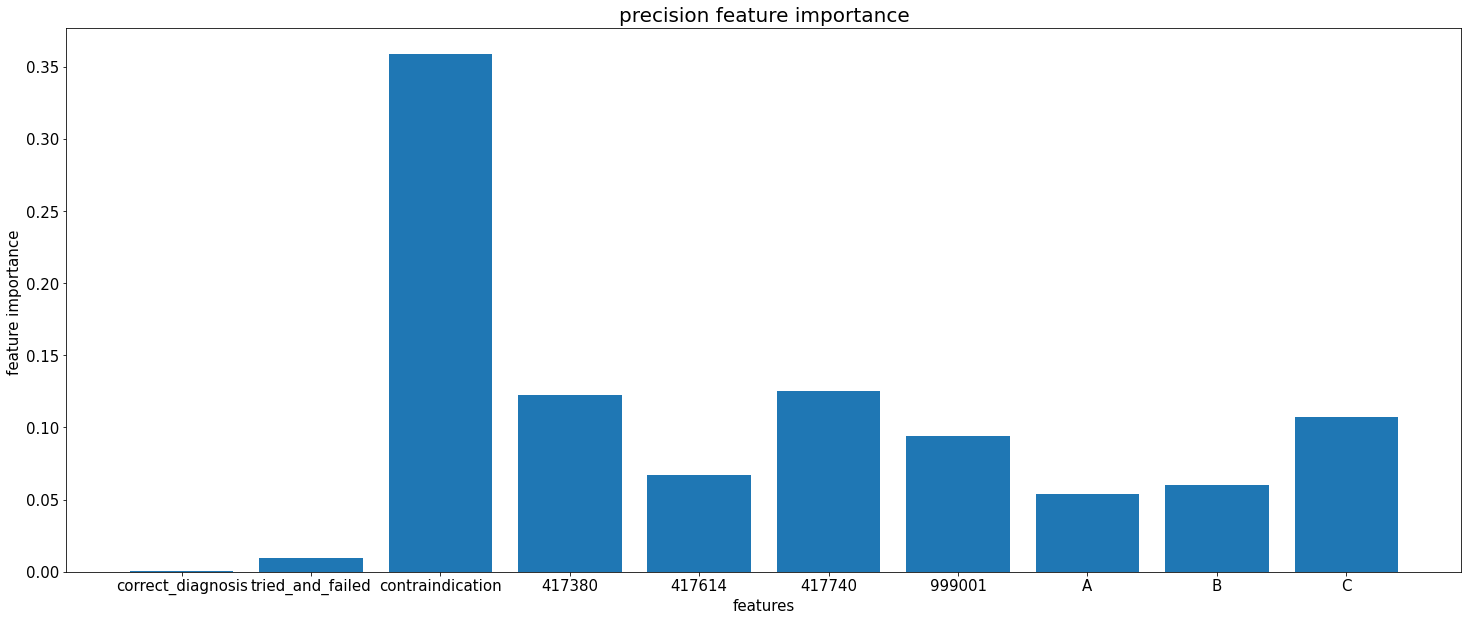



-true_positive_rate feature importance-

correct_diagnosis : 0.0
tried_and_failed : 0.072
contraindication : 0.256
417380 : 0.05
417614 : 0.035
417740 : 0.051
999001 : 0.08
A : 0.113
B : 0.227
C : 0.116


double click the image to zoom in and out


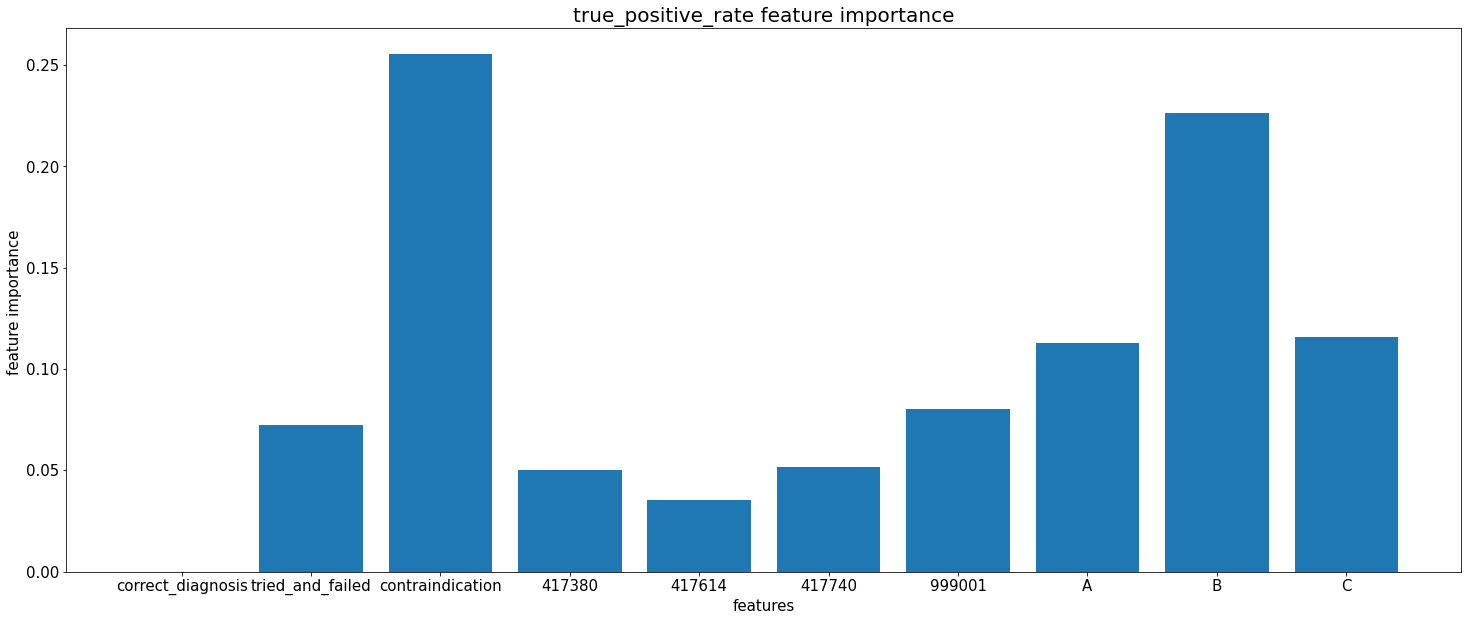



-false_positive_rate feature importance-

correct_diagnosis : 0.0
tried_and_failed : 0.072
contraindication : 0.256
417380 : 0.05
417614 : 0.035
417740 : 0.051
999001 : 0.08
A : 0.113
B : 0.227
C : 0.116


double click the image to zoom in and out


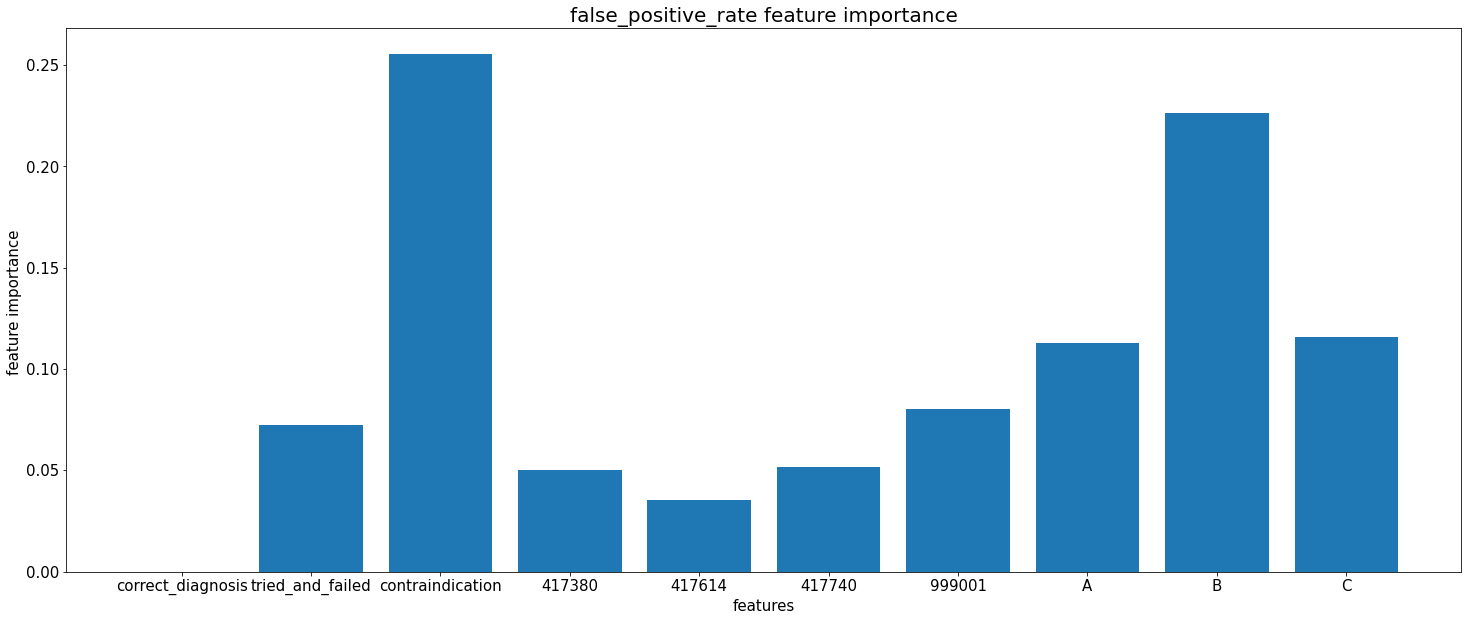



-f1 feature importance-

correct_diagnosis : 0.008
tried_and_failed : 0.039
contraindication : 0.081
417380 : 0.141
417614 : 0.209
417740 : 0.112
999001 : 0.059
A : 0.095
B : 0.147
C : 0.11


double click the image to zoom in and out


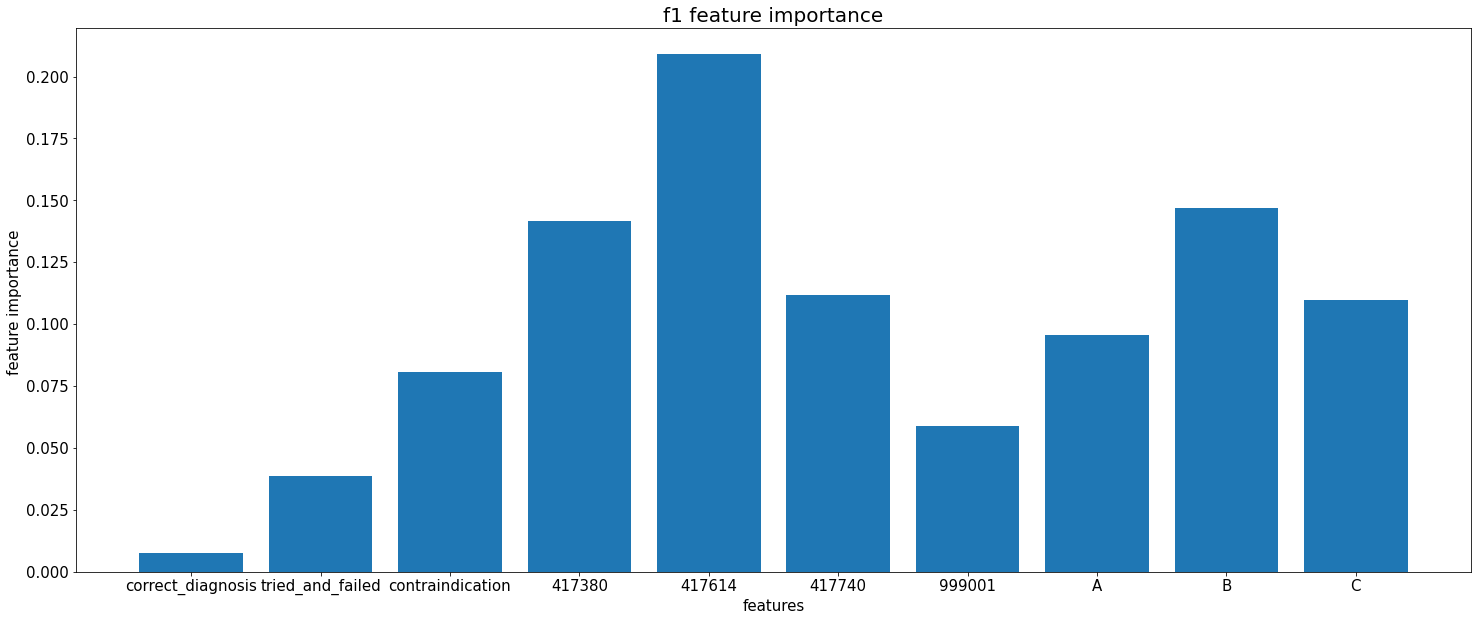



-roc_auc feature importance-

correct_diagnosis : 0.001
tried_and_failed : 0.007
contraindication : 0.031
417380 : 0.252
417614 : 0.101
417740 : 0.091
999001 : 0.115
A : 0.068
B : 0.042
C : 0.293


double click the image to zoom in and out


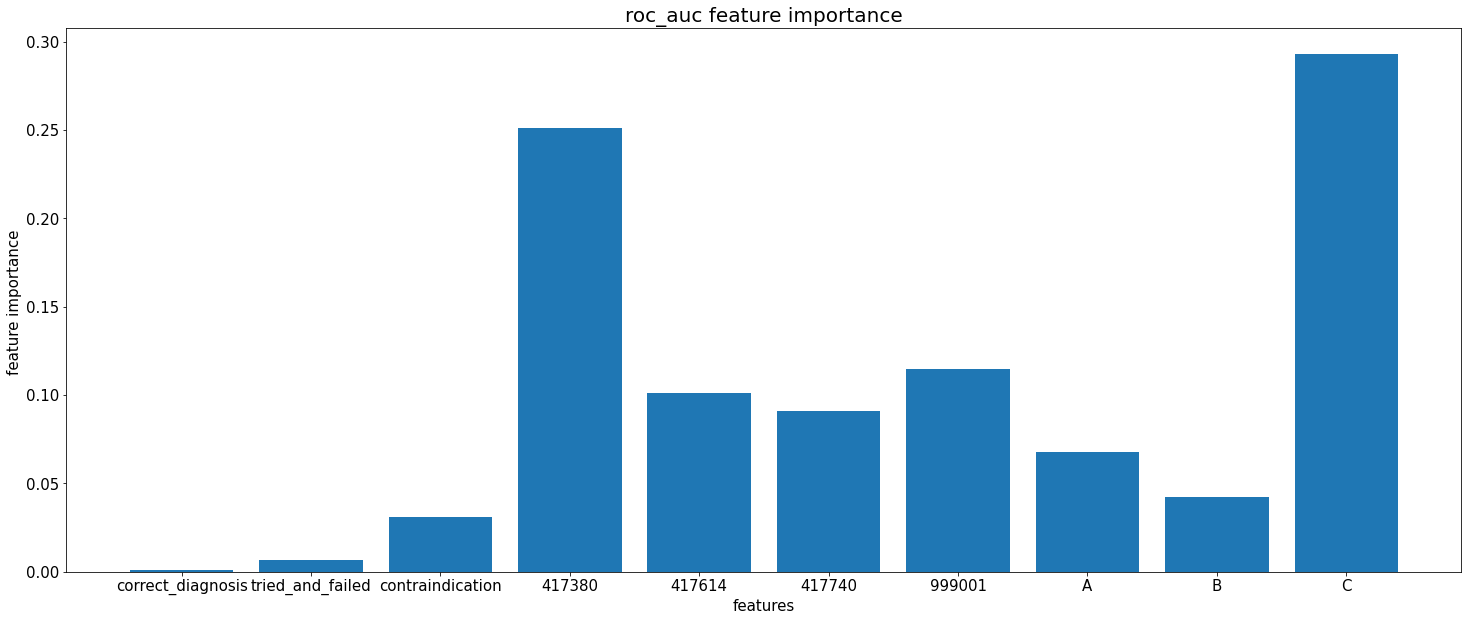

In [49]:
#summarize feature importances with respect to the accuracy_score 
print('\033[1m'+'-accuracy_score feature importance-')
print('\033[0m')
for i in range(len(acs_importance)):
        print(X_train.columns[i],':',round(acs_importance[i]/5,3))
# plot feature importances with respect to the accuracy_score 
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('accuracy_score feature importance', fontsize = 20)
plt.bar([x for x in X_pre.columns], acs_importance/5)
plt.show()  


print()
print()


#summarize feature importances with respect to the precision 
print('\033[1m'+'-precision feature importance-')
print('\033[0m')
for i in range(len(pre_importance)):
        print(X_train.columns[i],':',round(pre_importance[i]/5,3))
# plot feature importances with respect to the precision 
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('precision feature importance', fontsize = 20)
plt.bar([x for x in X_pre.columns], pre_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the  true_positive_rate    
print('\033[1m'+'-true_positive_rate feature importance-')
print('\033[0m')
for i in range(len(tpr_importance)):
        print(X_train.columns[i],':',round(tpr_importance[i]/5,3))
# plot feature importances with respect to the  true_positive_rate
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('true_positive_rate feature importance', fontsize = 20)
plt.bar([x for x in X_pre.columns], tpr_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the false_positive_rate 
print('\033[1m'+'-false_positive_rate feature importance-')
print('\033[0m')
for i in range(len(fpr_importance)):
        print(X_train.columns[i],':',round(fpr_importance[i]/5,3))
# plot feature importances with respect to the false_positive_rate
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('false_positive_rate feature importance', fontsize = 20)
plt.bar([x for x in X_pre.columns], fpr_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the f1   
print('\033[1m'+'-f1 feature importance-')
print('\033[0m')
for i in range(len(f1_importance)):
        print(X_train.columns[i],':',round(f1_importance[i]/5,3))
# plot feature importances with respect to the f1
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('f1 feature importance', fontsize = 20)
plt.bar([x for x in X_pre.columns], f1_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the roc_auc
print('\033[1m'+'-roc_auc feature importance-')
print('\033[0m')
for i in range(len(auc_importance)):
        print(X_train.columns[i],':',round(auc_importance[i]/5,3))
# plot feature importances with respect to the roc_auc
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('roc_auc feature importance', fontsize = 20)
plt.bar([x for x in X_pre.columns], auc_importance/5)
plt.show()    

In [50]:
X_train.columns

Index(['correct_diagnosis', 'tried_and_failed', 'contraindication', '417380',
       '417614', '417740', '999001', 'A', 'B', 'C'],
      dtype='object')

In [51]:
# accuracy_score
acs_importance[3] = max(acs_importance[3:7])
acs_importance[4] = max(acs_importance[7:])
acs_importance = acs_importance[:5]
# precision
pre_importance[3] = max(pre_importance[3:7])
pre_importance[4] = max(pre_importance[7:])
pre_importance = pre_importance[:5]
# true_positive_rate
tpr_importance[3] = max(tpr_importance[3:7])
tpr_importance[4] = max(tpr_importance[7:])
tpr_importance = tpr_importance[:5]
# false_positive_rate
fpr_importance[3] = max(fpr_importance[3:7])
fpr_importance[4] = max(fpr_importance[7:])
fpr_importance = fpr_importance[:5]
# f1
f1_importance[3] = max(f1_importance[3:7])
f1_importance[4] = max(f1_importance[7:])
f1_importance = f1_importance[:5]
# roc_auc
auc_importance[3] = max(auc_importance[3:7])
auc_importance[4] = max(auc_importance[7:])
auc_importance = auc_importance[:5]

In [52]:
features = list(X_train.columns.copy())
features[3] = 'bin'
features[4] = 'drug'
features = features[:5]
features

['correct_diagnosis', 'tried_and_failed', 'contraindication', 'bin', 'drug']

-accuracy_score feature importance-

correct_diagnosis : 0.011
tried_and_failed : 0.03
contraindication : 0.076
bin : 0.119
drug : 0.289


double click the image to zoom in and out


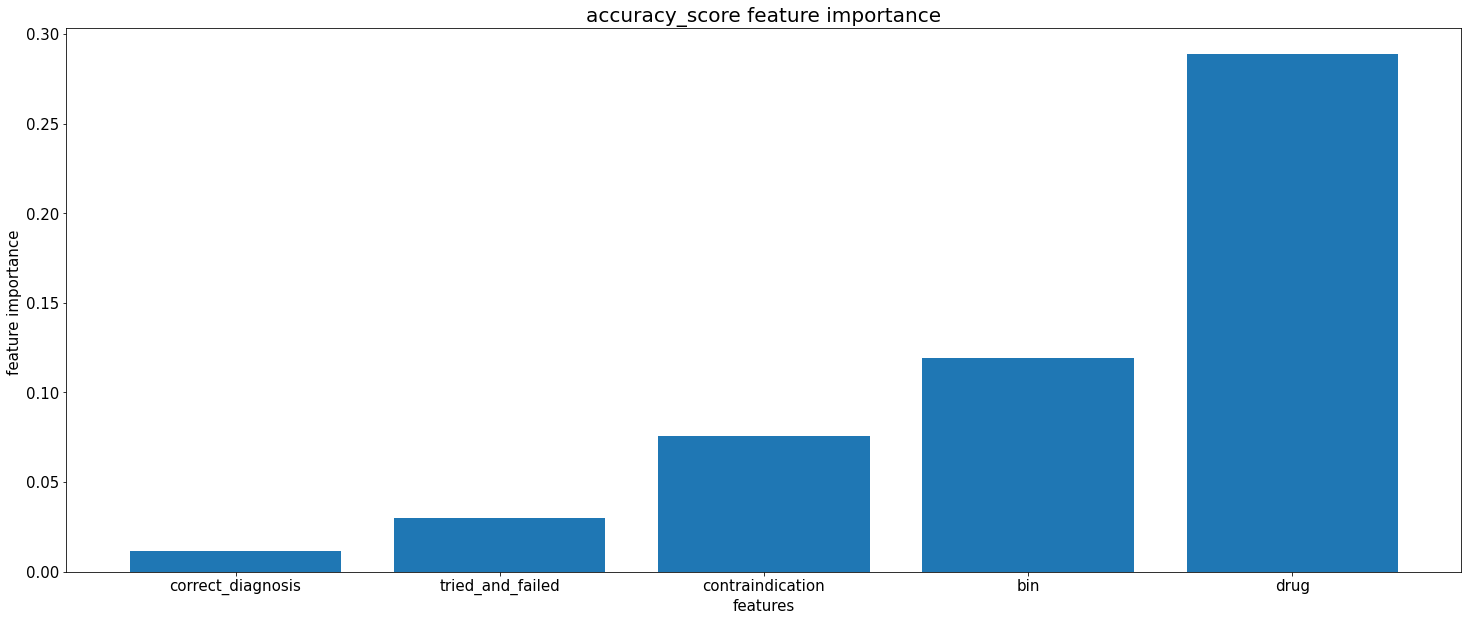



-precision feature importance-

correct_diagnosis : 0.001
tried_and_failed : 0.01
contraindication : 0.359
bin : 0.125
drug : 0.108


double click the image to zoom in and out


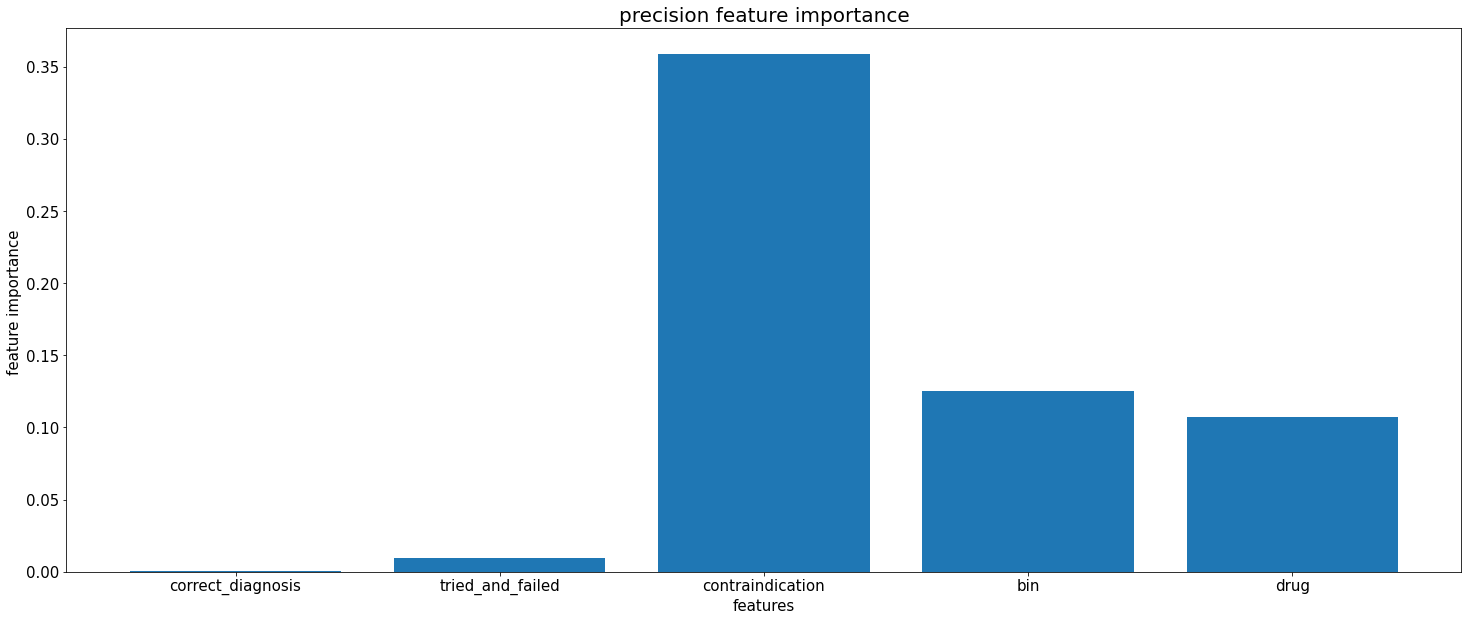



-true_positive_rate feature importance-

correct_diagnosis : 0.0
tried_and_failed : 0.072
contraindication : 0.256
bin : 0.08
drug : 0.227


double click the image to zoom in and out


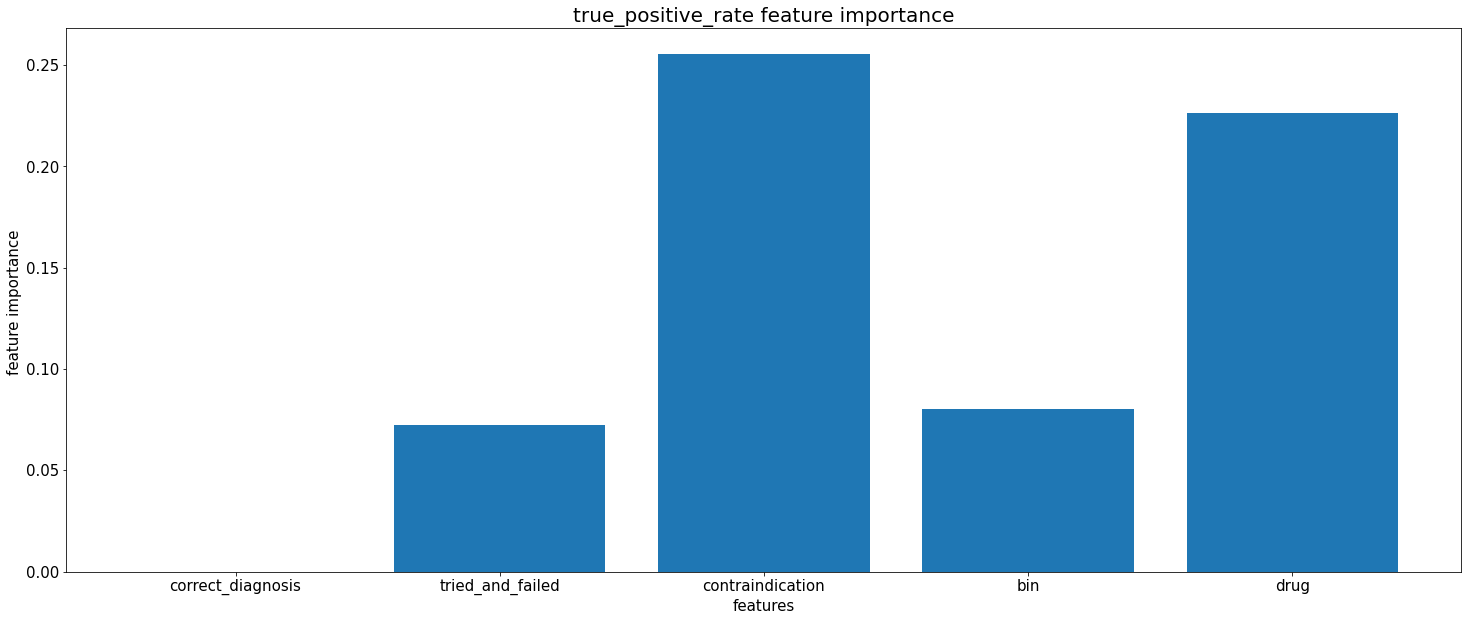



-false_positive_rate feature importance-

correct_diagnosis : 0.0
tried_and_failed : 0.072
contraindication : 0.256
bin : 0.08
drug : 0.227


double click the image to zoom in and out


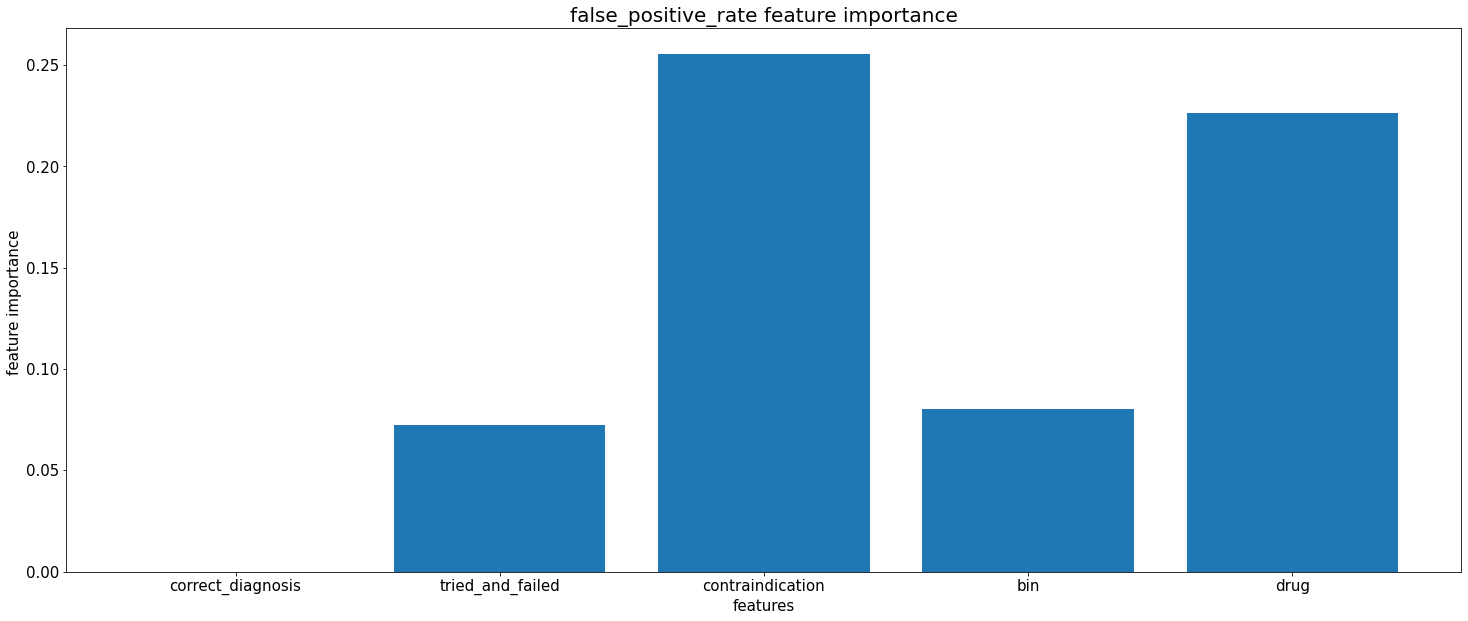



-f1 feature importance-

correct_diagnosis : 0.008
tried_and_failed : 0.039
contraindication : 0.081
bin : 0.209
drug : 0.147


double click the image to zoom in and out


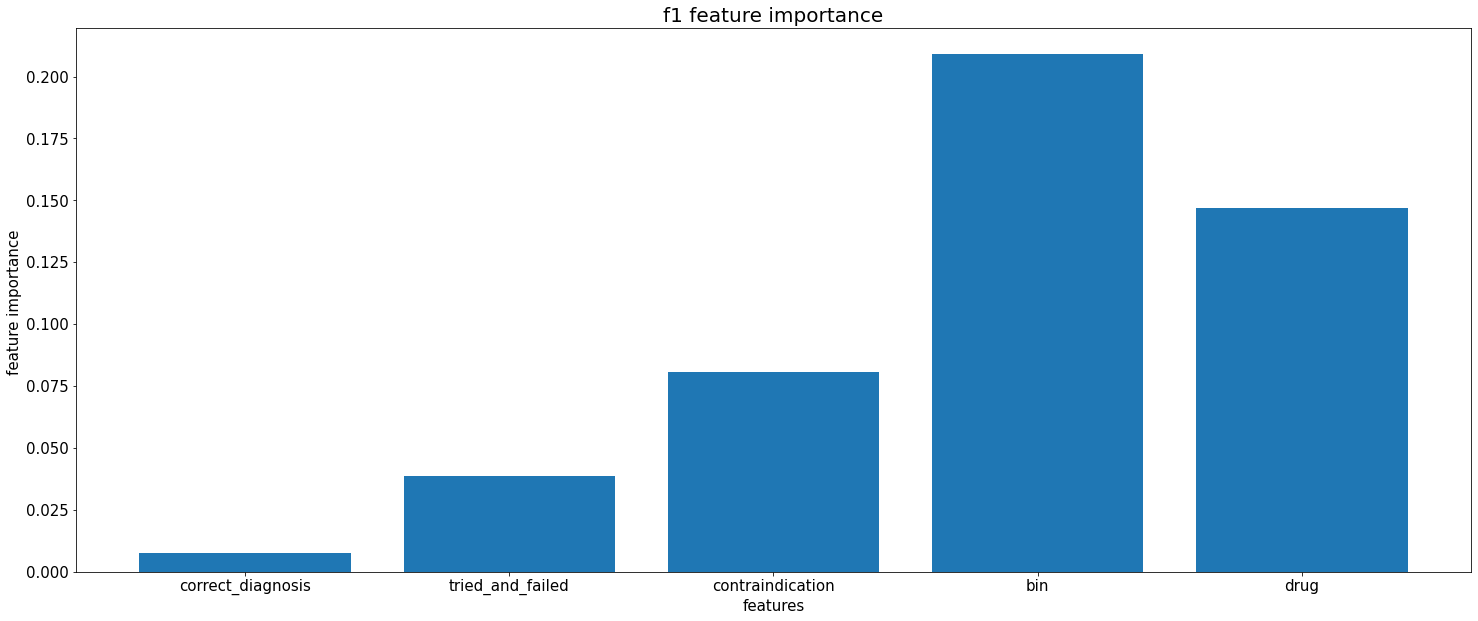



-roc_auc feature importance-

correct_diagnosis : 0.001
tried_and_failed : 0.007
contraindication : 0.031
bin : 0.252
drug : 0.293


double click the image to zoom in and out


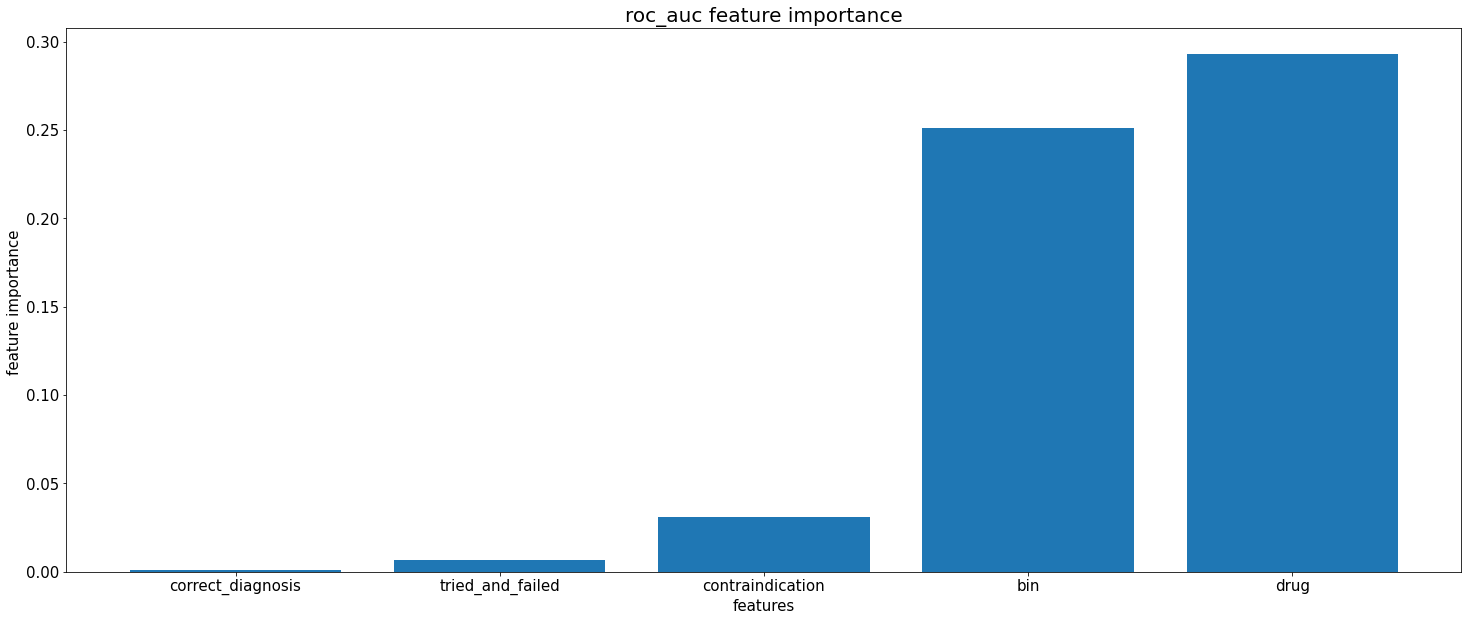

In [53]:
#summarize feature importances with respect to the accuracy_score
print('\033[1m'+'-accuracy_score feature importance-')
print('\033[0m')
for i in range(len(acs_importance)):
        print(features[i],':',round(acs_importance[i]/5,3))
# plot feature importances with respect to the accuracy_score
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('accuracy_score feature importance', fontsize = 20)
plt.bar(features, acs_importance/5)
plt.show()  


print()
print()


#summarize feature importances with respect to the precision
print('\033[1m'+'-precision feature importance-')
print('\033[0m')
for i in range(len(pre_importance)):
        print(features[i],':',round(pre_importance[i]/5,3))
# plot feature importances with respect to the precision
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('precision feature importance', fontsize = 20)
plt.bar(features, pre_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the true_positive_rate feature    
print('\033[1m'+'-true_positive_rate feature importance-')
print('\033[0m')
for i in range(len(tpr_importance)):
        print(features[i],':',round(tpr_importance[i]/5,3))
# plot feature importances with respect to the true_positive_rate feature
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('true_positive_rate feature importance', fontsize = 20)
plt.bar(features, tpr_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the false_positive_rate feature 
print('\033[1m'+'-false_positive_rate feature importance-')
print('\033[0m')
for i in range(len(fpr_importance)):
        print(features[i],':',round(fpr_importance[i]/5,3))
# plot feature importances with respect to the false_positive_rate feature
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('false_positive_rate feature importance', fontsize = 20)
plt.bar(features, fpr_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the f1    
print('\033[1m'+'-f1 feature importance-')
print('\033[0m')
for i in range(len(f1_importance)):
        print(features[i],':',round(f1_importance[i]/5,3))
# plot feature importances with respect to the f1 
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('f1 feature importance', fontsize = 20)
plt.bar(features, f1_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the roc_auc 
print('\033[1m'+'-roc_auc feature importance-')
print('\033[0m')
for i in range(len(auc_importance)):
        print(features[i],':',round(auc_importance[i]/5,3))
# plot feature importances with respect to the roc_auc 
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('roc_auc feature importance', fontsize = 20)
plt.bar(features, auc_importance/5)
plt.show()

In [54]:
# key performance indicators
kpis.loc['XGB','accuracy_score'] = round(np.mean(acses),3)
kpis.loc['XGB','precision'] = round(np.mean(pres),3)
kpis.loc['XGB','true_positive_rate'] = round(np.mean(tprs),3)
kpis.loc['XGB','false_positive_rate'] = round(np.mean(fprs),3)
kpis.loc['XGB','f1'] = round(np.mean(f1s),3)
kpis.loc['XGB','roc_auc'] = round(np.mean(aucs),3)

In [55]:
kpis

,accuracy_score,precision,true_positive_rate,false_positive_rate,f1,roc_auc
Base,0.734,0.734,1.000,1.000,0.847,0.500
Log,0.815,0.832,0.938,0.524,0.882,0.879
LDA,0.784,0.793,1.000,1.000,0.866,0.721
SVM,0.515,0.727,0.538,0.549,0.611,0.468
DT,0.815,0.838,1.000,1.000,0.879,0.879
RF,0.815,0.831,0.999,0.944,0.882,0.878
XGB,0.815,0.846,0.969,0.715,0.881,0.879


### -Key Performance Indicators-

In [56]:
#key performance indicators
kpis

,accuracy_score,precision,true_positive_rate,false_positive_rate,f1,roc_auc
Base,0.734,0.734,1.000,1.000,0.847,0.500
Log,0.815,0.832,0.938,0.524,0.882,0.879
LDA,0.784,0.793,1.000,1.000,0.866,0.721
SVM,0.515,0.727,0.538,0.549,0.611,0.468
DT,0.815,0.838,1.000,1.000,0.879,0.879
RF,0.815,0.831,0.999,0.944,0.882,0.878
XGB,0.815,0.846,0.969,0.715,0.881,0.879


- In terms of our key performance indicator(roc_auc score), logistic regression, decision tree, random forest and xgboost all perform the best. 
- These four models also performs equally well in terms of other metics such as accuracy_score, precision, true_positive_rate and f1 score.
- we cannot single out the best classification model based on the above observations.
- However, logistic regression has significantly lower false_positive_rate compared to other four models. 
- Therefore, we select Logistic Regression as our classifier.

# 2. Save Key Performance Indicators

In [57]:
# save dataframes as csv files
kpis.to_csv('data/kpis_train',header = True, index = True)